### This notebook is designed to make a Dataframe with rear events that are borderless and associate the beacon location with it
it also needs to subtract a shift in position of the beacons and create indices for Vissucc, InvisSucc or InvisUnsecc.
Then it shoud plot the histograms and save them in figures. Best would be to make one long Data Frame per animal - next step tomorrow.

In [4]:
import math
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from numpy import median
from scipy.stats import ranksums

import numpy as np
import scipy.stats

import os
import fnmatch

In [108]:
root3 = '//10.153.170.3/storage2/fabian/data/raw/Event_files_FS03/'
root4 = '//10.153.170.3/storage2/fabian/data/raw/Event_files_FS04/'
figures = 'C:/Users/Fabian/Desktop/Analysis/Round3_FS03_FS06/Figures/'
animal = '//10.153.170.3/storage2/fabian/data/raw/Event_files_FS03/'
processed= 'C:/Users/Fabian/Desktop/Analysis/Round3_FS03_FS06/processed/'

FS03_position= pd.read_csv(root3+'position_20210312-172823.txt',sep=" ", header=None)
FS04_position = pd.read_csv(root4+'position_20210322-202458.txt',sep=" ", header=None)

FS03_beacon = pd.read_csv(root3+'beacons_20210312-172823.txt',sep=" ", header=None)
FS04_beacon = pd.read_csv(root4+'beacons_20210322-202458.txt',sep=" ", header=None)

FS03_metadata = pd.read_csv(root3+'metadata_20210312-172823.txt',sep=" ", header=None)
pd.options.display.float_format = '{:.3f}'.format

### Borders of arena.

In [109]:
cut=0
X_cut_min = -.6
Y_cut_max = 1.5
X_cut_max = .1
Y_cut_min = .08

### get secific point per rear event in center of arena

In [125]:
def Z_period_points(positions): 
    high =0 
    low = 0
    switch = 0 
    last = .60
    high_points=[]
    z= positions[2]
    count = 0 
    for height in z: 
        if height >.62 and last<.62:
            high +=1  
            if  (X_cut_min+cut)< positions[1][count]<(X_cut_max-cut) and (Y_cut_min+cut)< positions[3][count]<(Y_cut_max-cut):
                high_points.append((positions[0][count],positions[1][count],positions[3][count],positions[2][count]))
        last = height
        count +=1
        
    return pd.DataFrame(high_points)
Z_points= Z_period_points(FS03_position)
Z_points.head()

,0,1,2,3
0,1615566506.380,-0.509,0.334,0.628
1,1615566510.780,-0.441,0.248,0.625
2,1615566529.700,-0.425,0.719,0.629
3,1615566572.920,-0.501,0.392,0.625
4,1615566574.530,-0.487,0.271,0.622


### Add 6th column ot beacon if visible or not

In [111]:
def vis_invis(beacon): 
    visibility=[]
    for i in beacon.index:
        if(i % 2 == 0):
            visibility.append(1)
        else:
            visibility.append(0)
    beacon[6]=visibility
    return beacon
FS03_beacon=vis_invis(FS03_beacon)    
FS03_beacon.head()

,0,1,2,3,4,5,6
0,1615566511.420,-0.403,0.693,0.304,-0.177,-0.524,1
1,1615566575.040,-0.477,0.689,0.286,-0.177,-0.524,0
2,1615566591.520,-0.486,0.660,0.339,-0.177,-0.524,1
3,1615566654.670,-0.436,0.699,0.326,-0.177,-0.524,0
4,1615566660.580,-0.432,0.723,0.291,-0.177,-0.524,1


### Find succesfull invisible trials and name them 2 inthe 6th column

In [112]:
def invis_succ(beacon):
    invis=[]
    #for ind in FS03_beacon.index:
    df = beacon[0].diff().to_frame()
    for ind in df.index:
        if df[0][ind]<60 and not (ind % 2 == 0):
            invis.append(ind)
            beacon[6][ind]=2
    return beacon
#invis_succ(FS03_beacon)


### Create data frame with matching to append invisibility or not and substarct position from rears so it is centralized.

### Position normalization - hardcoded by experimenting

In [113]:
x_max, x_min = 0.2, -0.76
x_offset = x_max - (x_max - x_min)/2
y_max, y_min = 0.072,  -1.754
y_offset = y_max - (y_max - y_min)/2
print(x_offset,y_offset)

-0.27999999999999997 -0.8410000000000001


In [114]:
def match_and_append(Z_points,beacon):
    df_rears = Z_points
    Xs=[]
    Ys=[]
    visibility=[]
    for row in Z_points.iterrows():
        #print(row[1][0])
        k = beacon.iloc[(beacon[0] - row[1][0]).abs().argsort()[:1]]
        #print(k.values[0][4])
        Xs.append(k.values[0][4])
        Ys.append(k.values[0][5])
        visibility.append(k.values[0][6])


        #print(FS03_position[0][list(k.index)])
        #pos_index.append(int(''.join(map(str,list(k.index)))))
    df_rears[4]=Xs
    df_rears[5]=Ys
    df_rears[6]=visibility
    df_rears_corrected=df_rears
    df_rears_corrected[1]=df_rears[1]-x_offset
    df_rears_corrected[2]=df_rears[2]+y_offset
    return df_rears_corrected
match_and_append(Z_points,FS03_beacon)
#df_rears_corrected.head(15)


,0,1,2,3,4,5,6
0,1615566506.380,-0.229,-0.507,0.628,-0.177,-0.524,1.000
1,1615566510.780,-0.161,-0.593,0.625,-0.177,-0.524,1.000
2,1615566529.700,-0.145,-0.122,0.629,-0.177,-0.524,1.000
3,1615566572.920,-0.221,-0.449,0.625,-0.177,-0.524,0.000
4,1615566574.530,-0.207,-0.570,0.622,-0.177,-0.524,0.000
5,1615566591.010,-0.208,-0.500,0.620,-0.177,-0.524,1.000
6,1615566603.830,-0.281,-0.545,0.628,-0.177,-0.524,1.000
7,1615566607.220,-0.318,-0.603,0.625,-0.177,-0.524,1.000
8,1615566654.160,-0.134,-0.462,0.622,-0.177,-0.524,0.000
9,1615566659.350,-0.197,-0.537,0.621,-0.177,-0.524,1.000


### Now all in one cell

In [115]:
FS03_position= pd.read_csv(root3+'position_20210312-172823.txt',sep=" ", header=None)
FS04_position = pd.read_csv(root4+'position_20210322-202458.txt',sep=" ", header=None)

FS03_beacon = pd.read_csv(root3+'beacons_20210312-172823.txt',sep=" ", header=None)
FS04_beacon = pd.read_csv(root4+'beacons_20210322-202458.txt',sep=" ", header=None)

Z_points= Z_period_points(FS03_position)
FS03_beacon=vis_invis(FS03_beacon)
FS03_beacon=invis_succ(FS03_beacon)
match_and_append(Z_points,FS03_beacon)

D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,0,1,2,3,4,5,6
0,1615566506.380,-0.229,-0.507,0.628,-0.177,-0.524,1.000
1,1615566510.780,-0.161,-0.593,0.625,-0.177,-0.524,1.000
2,1615566529.700,-0.145,-0.122,0.629,-0.177,-0.524,1.000
3,1615566572.920,-0.221,-0.449,0.625,-0.177,-0.524,0.000
4,1615566574.530,-0.207,-0.570,0.622,-0.177,-0.524,0.000
5,1615566591.010,-0.208,-0.500,0.620,-0.177,-0.524,1.000
6,1615566603.830,-0.281,-0.545,0.628,-0.177,-0.524,1.000
7,1615566607.220,-0.318,-0.603,0.625,-0.177,-0.524,1.000
8,1615566654.160,-0.134,-0.462,0.622,-0.177,-0.524,0.000
9,1615566659.350,-0.197,-0.537,0.621,-0.177,-0.524,1.000


### Run it in a loop to make one data frame 

In [81]:
def make_rearing_df(position,beacon):
    Z_points= Z_period_points(position)
    beacon=vis_invis(beacon)
    beacon=invis_succ(beacon)
    rearing_df=match_and_append(Z_points,beacon)
    return rearing_df
pp=make_rearing_df(FS03_position,FS03_beacon)
rr=make_rearing_df(FS03_position,FS03_beacon)
kk= pp.append(rr,ignore_index=True)
#kk=pd.concat([pp,rr],ignore_index=True)
kk

D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,0,1,2,3,4,5,6
0,1615566506.380,-0.229,-0.507,0.628,-0.177,-0.524,1.000
1,1615566510.780,-0.161,-0.593,0.625,-0.177,-0.524,1.000
2,1615566529.700,-0.145,-0.122,0.629,-0.177,-0.524,1.000
3,1615566572.920,-0.221,-0.449,0.625,-0.177,-0.524,0.000
4,1615566574.530,-0.207,-0.570,0.622,-0.177,-0.524,0.000
5,1615566591.010,-0.208,-0.500,0.620,-0.177,-0.524,1.000
6,1615566603.830,-0.281,-0.545,0.628,-0.177,-0.524,1.000
7,1615566607.220,-0.318,-0.603,0.625,-0.177,-0.524,1.000
8,1615566654.160,-0.134,-0.462,0.622,-0.177,-0.524,0.000
9,1615566659.350,-0.197,-0.537,0.621,-0.177,-0.524,1.000


In [83]:
rearing = pd.DataFrame()
rearing

""


filename: HERE FS04-20210210a.txt
filename: HERE FS04-20210204a.txt
filename: HERE FS04-20210218b.txt
filename: HERE chan_order
filename: HERE chan_order~
filename: HERE Video 114.wmv
filename: HERE FS04-20210211a.txt
filename: HERE FS04_OLD_badChannels.xml
filename: HERE FS04_old.xml
filename: HERE FS04-20210206a.txt
filename: HERE FS04-20210218a.txt
filename: HERE FS04-20210215a.txt
filename: HERE process_ndm~
filename: HERE FS04-20210216a.txt
filename: HERE FS04.xml
filename: HERE Video 112.wmv
filename: HERE FS04-20210217a.txt
filename: HERE FS04-20210215b.txt
filename: HERE FS04-20210208a.txt
filename: HERE FS04-20210219a.txt
filename: HERE FS04-20210209a.txt
filename: HERE FS04-20210220a.txt
filename: HERE Video 113.wmv
filename: HERE FS04-20210222a.txt
filename: HERE FS04-20210222b.txt
filename: HERE FS04-20210224a.txt
filename: HERE FS04-20210223a.txt
filename: HERE FS04-20210223b.txt
filename: HERE FS04-20210304a.txt
filename: HERE FS04-20210224b.txt
filename: HERE FS04-202102

D:\Software\anaconda\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


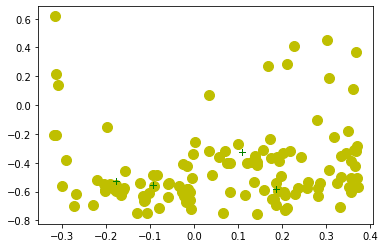

filename: HERE HSW_2021_02_23__18_32_33__28min_25sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_23__18_32_33__28min_25sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_23__18_32_33__28min_25sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_23__18_32_33__28min_25sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_02_04__18_45_49__04min_59sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_04__18_45_49__04min_59sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_04__18_45_49__04min_59sec__hsamp_64ch_25000sps.nrs
filename: HERE FS04.xml
filename: HERE HSW_2021_02_22__18_48_50__28min_59sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_22__18_48_50__28min_59sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_22__18_48_50__28min_59sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_22__18_48_50__28min_59sec__hsamp_64ch_25000sps.nrs
filename: HERE Take 2021-02-22 06.48.35 PM.csv
filename: HERE vrr
filename: HERE FS04-20210222-184854.xlsx
filename: H

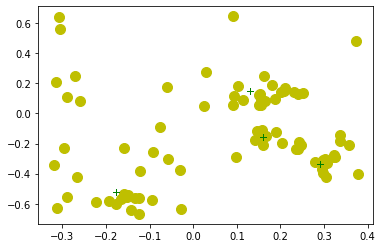

filename: HERE HSW_2021_02_06__19_54_34__07min_48sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_06__19_54_34__07min_48sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_06__19_54_34__07min_48sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_06__19_54_34__07min_48sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_02_17__11_29_53__23min_52sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_17__11_29_53__23min_52sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_17__11_29_53__23min_52sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_17__11_29_53__23min_52sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_02_18__12_07_51__44min_36sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_18__12_07_51__44min_36sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_18__12_07_51__44min_36sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_19__08_59_47__111min_06sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_19__08_59_47__111min_06sec__hsamp_64

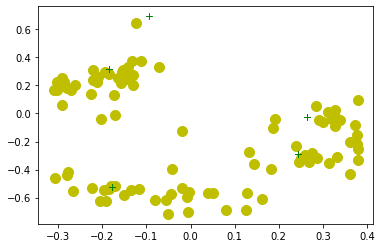

filename: HERE HSW_2021_02_17__15_14_51__45min_23sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_17__15_14_51__45min_23sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_17__15_14_51__45min_23sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_20__15_41_22__31min_06sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_20__15_41_22__31min_06sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_20__15_41_22__31min_06sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_20__15_41_22__31min_06sec__hsamp_64ch_25000sps.nrs
filename: HERE Take 2021-02-20 03.39.44 PM.csv
filename: HERE vrr
filename: HERE FS04-20210220-154122.xlsx
filename: HERE 2Dhist_20210220-154122.png
filename: HERE 3D_20210220-154122.png
filename: HERE hist_20210220-154122.png
filename: HERE beacons_20210220-154122.txt
beacons_20210220-154122.txt
 found!
filename: HERE beacon_entry_20210220-154122.txt
filename: HERE metadata_20210220-154122.txt
filename: HERE position_20210220-154122.txt
position_202

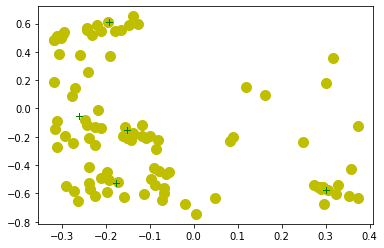

filename: HERE HSW_2021_02_09__12_46_35__48min_44sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_09__12_46_35__48min_44sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_09__12_46_35__48min_44sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_09__12_46_35__48min_44sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_02_09__11_05_24__101min_15sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_09__11_05_24__101min_15sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_09__11_05_24__101min_15sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_09__11_05_24__101min_15sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_02_23__10_05_46__30min_51sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_23__10_05_46__30min_51sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_23__10_05_46__30min_51sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_23__10_05_46__30min_51sec__hsamp_64ch_25000sps.nrs
filename: HERE Take 2021-02-23 10.04.30 AM.csv
filename: HER

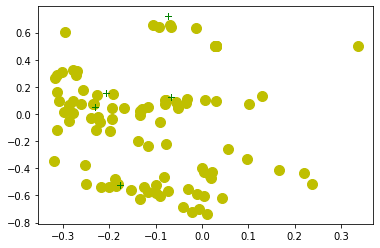

filename: HERE 2Dhist_20210223-100549.png
filename: HERE 3D_20210223-100549.png
filename: HERE hist_20210223-100549.png
filename: HERE HSW_2021_02_08__18_28_50__01min_50sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_08__18_28_50__01min_50sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_08__18_28_50__01min_50sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_08__18_28_50__01min_50sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_02_18__11_59_12__06min_30sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_18__11_59_12__06min_30sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_18__11_59_12__06min_30sec__hsamp_64ch_25000sps.xml
filename: HERE FS04-20210218-113456.xlsx
filename: HERE 2Dhist_20210218-113456.png
filename: HERE 3D_20210218-113456.png
filename: HERE hist_20210218-113456.png
filename: HERE beacons_20210218-113456.txt
beacons_20210218-113456.txt
 found!
filename: HERE beacon_entry_20210218-113456.txt
filename: HERE metadata_20210218-113456.txt
fi

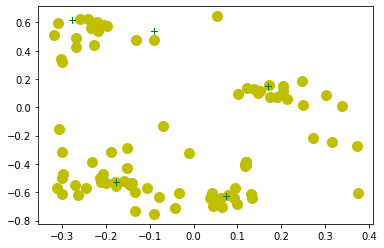

filename: HERE HSW_2021_02_10__19_23_24__14min_43sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_10__19_23_24__14min_43sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_10__19_23_24__14min_43sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_10__19_23_24__14min_43sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_02_23__19_00_59__33min_25sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_23__19_00_59__33min_25sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_23__19_00_59__33min_25sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_23__19_00_59__33min_25sec__hsamp_64ch_25000sps.nrs
filename: HERE Take 2021-02-23 06.59.56 PM.csv
filename: HERE vrr
filename: HERE FS04-20210223-190059.xlsx
filename: HERE 2Dhist_20210223-190059.png
filename: HERE 3D_20210223-190059.png
filename: HERE hist_20210223-190059.png
filename: HERE beacons_20210223-190059.txt
beacons_20210223-190059.txt
 found!
filename: HERE beacon_entry_20210223-190059.txt
filename: HERE metadat

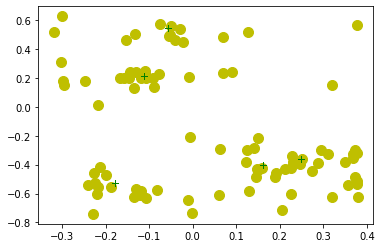

filename: HERE HSW_2021_02_11__08_52_01__97min_22sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_11__08_52_01__97min_22sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_11__08_52_01__97min_22sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_11__08_52_01__97min_22sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_02_17__11_19_06__06min_23sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_17__11_19_06__06min_23sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_17__11_19_06__06min_23sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_19__15_40_59__31min_09sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_19__15_40_59__31min_09sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_19__15_40_59__31min_09sec__hsamp_64ch_25000sps.xml
filename: HERE Take 2021-02-19 03.36.45 PM.csv
filename: HERE vrr
filename: HERE FS04-20210219-154114.xlsx
filename: HERE beacons_20210219-154114.txt
beacons_20210219-154114.txt
 found!
filename: HERE beacon_entry_202102

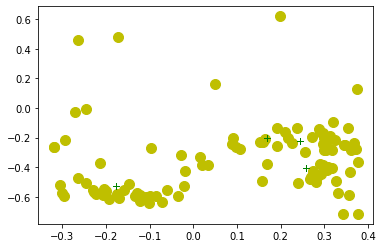

filename: HERE 2Dhist_20210219-154114.png
filename: HERE 3D_20210219-154114.png
filename: HERE hist_20210219-154114.png
filename: HERE HSW_2021_02_15__11_09_02__41min_24sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_15__11_09_02__41min_24sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_15__11_09_02__41min_24sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_15__11_09_02__41min_24sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_02_18__11_34_53__24min_19sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_18__11_34_53__24min_19sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_18__11_34_53__24min_19sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_18__11_34_53__24min_19sec__hsamp_64ch_25000sps.nrs
filename: HERE Video 106.wmv
filename: HERE Take 2021-02-18 11.34.34 AM.csv
filename: HERE vrr
filename: HERE FS04-20210218-113456.xlsx
filename: HERE 2Dhist_20210218-113456.png
filename: HERE 3D_20210218-113456.png
filename: HERE hist_20210218-113456.png


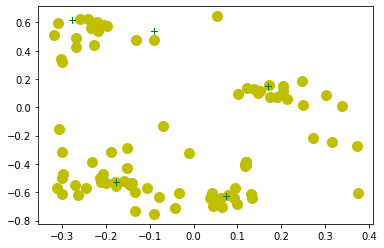

filename: HERE HSW_2021_02_24__19_02_37__32min_13sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_24__19_02_37__32min_13sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_24__19_02_37__32min_13sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_24__19_02_37__32min_13sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_02_24__19_02_37__32min_13sec__hsamp_64ch_25000sps.lfp
filename: HERE HSW_2021_02_24__19_02_37__32min_13sec__hsamp_64ch_25000sps.fil
filename: HERE HSW_2021_02_24__19_02_37__32min_13sec__hsamp_64ch_25000sps.klg.1
filename: HERE HSW_2021_02_24__19_02_37__32min_13sec__hsamp_64ch_25000sps.klg.2
filename: HERE HSW_2021_02_24__19_02_37__32min_13sec__hsamp_64ch_25000sps.klg.3
filename: HERE HSW_2021_02_24__19_02_37__32min_13sec__hsamp_64ch_25000sps.klg.4
filename: HERE HSW_2021_02_24__19_02_37__32min_13sec__hsamp_64ch_25000sps.klg.5
filename: HERE HSW_2021_02_24__19_02_37__32min_13sec__hsamp_64ch_25000sps.klg.6
filename: HERE HSW_2021_02_24__19_02_37__32min_13sec

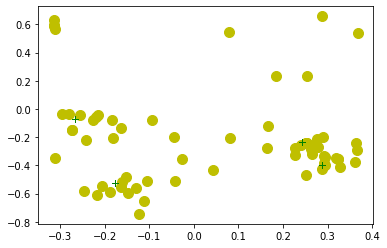

filename: HERE 2Dhist_20210224-190236.png
filename: HERE 3D_20210224-190236.png
filename: HERE hist_20210224-190236.png
filename: HERE HSW_2021_02_15__18_43_03__30min_44sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_15__18_43_03__30min_44sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_15__18_43_03__30min_44sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_15__18_43_03__30min_44sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_03_04__21_35_39__01min_20sec__hsamp_64ch_25000sps.bin
filename: HERE FS04-20210215-184133.xlsx
filename: HERE 2Dhist_20210215-184133.png
filename: HERE 3D_20210215-184133.png
filename: HERE hist_20210215-184133.png
filename: HERE beacons_20210215-184133.txt
beacons_20210215-184133.txt
 found!
filename: HERE beacon_entry_20210215-184133.txt
filename: HERE metadata_20210215-184133.txt
filename: HERE position_20210215-184133.txt
position_20210215-184133.txt
 found! 
Match found making rearing file


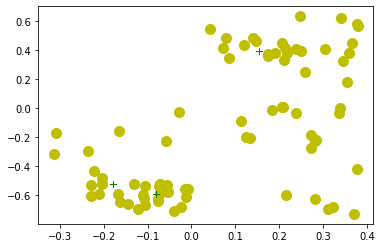

filename: HERE HSW_2021_02_22__18_14_54__33min_51sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_22__18_14_54__33min_51sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_22__18_14_54__33min_51sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_22__18_14_54__33min_51sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_02_23__08_29_12__95min_23sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_23__08_29_12__95min_23sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_23__08_29_12__95min_23sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_23__08_29_12__95min_23sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_02_16__14_01_16__26min_49sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_16__14_01_16__26min_49sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_16__14_01_16__26min_49sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_17__10_46_25__32min_16sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_17__10_46_25__32min_16sec__hsamp_64ch

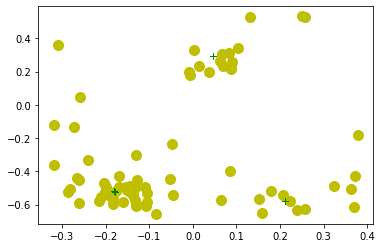

filename: HERE 2Dhist_20210217-104716.png
filename: HERE 3D_20210217-104716.png
filename: HERE hist_20210217-104716.png
filename: HERE HSW_2021_02_18__10_26_15__65min_52sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_18__10_26_15__65min_52sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_18__10_26_15__65min_52sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_18__10_26_15__65min_52sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_02_23__10_41_48__179min_13sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_16__16_53_19__32min_00sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_16__16_53_19__32min_00sec__hsamp_64ch_25000sps.dat
filename: HERE Take 2021-02-16 04.52.25 PM.csv
filename: HERE HSW_2021_02_16__16_53_19__32min_00sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_16__16_53_19__32min_00sec__hsamp_64ch_25000sps.nrs
filename: HERE vrr
filename: HERE FS04-20210216-165334.xlsx
filename: HERE beacons_20210216-165334.txt
beacons_20210216-165334.txt

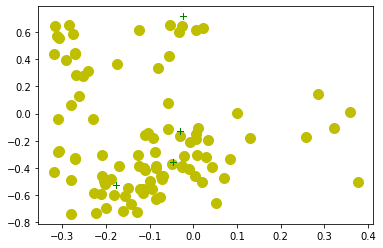

filename: HERE 2Dhist_20210216-165334.png
filename: HERE 3D_20210216-165334.png
filename: HERE hist_20210216-165334.png
filename: HERE HSW_2021_04_20__15_08_04__98min_59sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_20__15_08_04__98min_59sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_20__15_08_04__98min_59sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_22__11_06_02__115min_35sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_22__11_06_02__115min_35sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_22__11_06_02__115min_35sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_22__11_06_02__115min_35sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_02_18__19_11_14__30min_50sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_18__19_11_14__30min_50sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_18__19_11_14__30min_50sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_18__19_11_14__30min_50sec__hsamp_64ch_25000sps.nrs
filename: HERE Tak

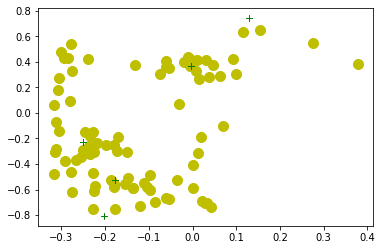

filename: HERE HSW_2021_02_22__13_07_42__32min_01sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_22__13_07_42__32min_01sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_22__13_07_42__32min_01sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_22__13_07_42__32min_01sec__hsamp_64ch_25000sps.nrs
filename: HERE Take 2021-02-22 01.07.35 PM.csv
filename: HERE vrr
filename: HERE FS04-20210222-130751.xlsx
filename: HERE beacons_20210222-130751.txt
beacons_20210222-130751.txt
 found!
filename: HERE beacon_entry_20210222-130751.txt
filename: HERE metadata_20210222-130751.txt
filename: HERE position_20210222-130751.txt
position_20210222-130751.txt
 found! 
Match found making rearing file


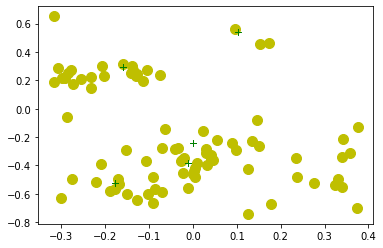

filename: HERE 2Dhist_20210222-130751.png
filename: HERE 3D_20210222-130751.png
filename: HERE hist_20210222-130751.png
filename: HERE HSW_2021_02_17__09_30_55__74min_32sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_17__09_30_55__74min_32sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_17__09_30_55__74min_32sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_18__10_09_53__12min_32sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_18__10_09_53__12min_32sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_18__10_09_53__12min_32sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_24__15_36_23__31min_23sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_24__15_36_23__31min_23sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_24__15_36_23__31min_23sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_24__15_36_23__31min_23sec__hsamp_64ch_25000sps.nrs
filename: HERE Take 2021-02-24 03.26.34 PM.csv
filename: HERE vrr
filename: HERE FS04-20210224-15362

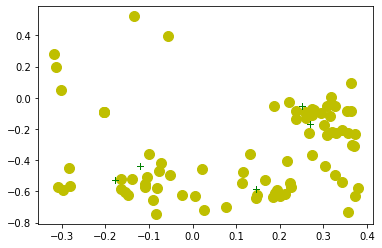

filename: HERE 2Dhist_20210224-153624.png
filename: HERE 3D_20210224-153624.png
filename: HERE hist_20210224-153624.png
filename: HERE HSW_2021_02_19__11_28_21__35min_46sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_19__11_28_21__35min_46sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_19__11_28_21__35min_46sec__hsamp_64ch_25000sps.xml
filename: HERE Take 2021-02-16 04.52.25 PM.tak
filename: HERE Take 2021-02-17 02.43.22 PM.tak
filename: HERE Take 2021-02-17 10.44.50 AM.tak
filename: HERE Take 2021-02-18 07.10.48 PM.tak
filename: HERE Take 2021-02-18 11.34.34 AM.tak
filename: HERE Take 2021-02-19 03.36.45 PM.tak
filename: HERE _001.tak
filename: HERE Take 2021-02-20 03.39.44 PM.tak
filename: HERE Take 2021-02-22 01.07.35 PM.tak
filename: HERE Take 2021-02-22 06.48.35 PM.tak
filename: HERE Take 2021-02-23 10.04.30 AM.tak
filename: HERE HSW_2021_02_24__18_28_35__32min_53sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_24__18_28_35__32min_53sec__hsamp_64ch_25000sps.

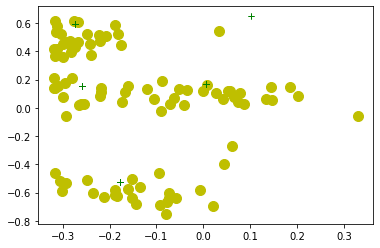

filename: HERE HSW_2021_02_24__14_10_05__76min_03sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_24__14_10_05__76min_03sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_24__14_10_05__76min_03sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_01__17_02_24__179min_13sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_01__17_02_24__179min_13sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_01__17_02_24__179min_13sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_01__17_02_24__179min_13sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_03_05__13_20_04__30min_28sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_05__13_20_04__30min_28sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_05__13_20_04__30min_28sec__hsamp_64ch_25000sps.xml
filename: HERE Take 2021-03-05 01.18.34 PM.csv
filename: HERE vrr
filename: HERE FS04-20210305-132010.xlsx
filename: HERE beacons_20210305-132010.txt
beacons_20210305-132010.txt
 found!
filename: HERE beacon_entry_20

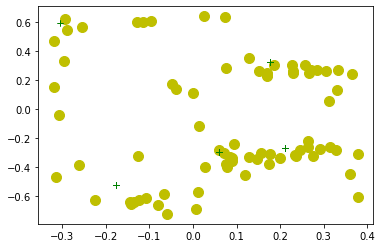

filename: HERE 2Dhist_20210305-132010.png
filename: HERE 3D_20210305-132010.png
filename: HERE hist_20210305-132010.png
filename: HERE HSW_2021_03_09__18_53_06__05min_54sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_09__18_53_06__05min_54sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_09__18_53_06__05min_54sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_09__18_53_06__05min_54sec__hsamp_64ch_25000sps.nrs
filename: HERE Take 2021-03-09 06.51.34 PM.csv
filename: HERE vrr
filename: HERE HSW_2021_03_02__09_04_05__28min_18sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_02__09_04_05__28min_18sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_02__09_04_05__28min_18sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_02__09_04_05__28min_18sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_03_02__19_36_51__36min_29sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_02__19_36_51__36min_29sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_02__19_

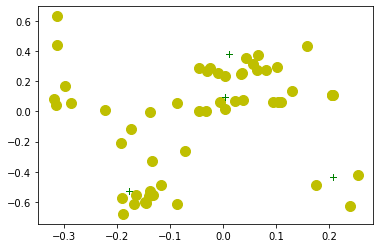

filename: HERE HSW_2021_03_06__15_29_21__12min_09sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_06__15_29_21__12min_09sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_06__15_29_21__12min_09sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_06__15_29_21__12min_09sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_02_25__11_27_55__30min_16sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_25__11_27_55__30min_16sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_25__11_27_55__30min_16sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_25__11_27_55__30min_16sec__hsamp_64ch_25000sps.lfp
filename: HERE HSW_2021_02_25__11_27_55__30min_16sec__hsamp_64ch_25000sps.fil
filename: HERE HSW_2021_02_25__11_27_55__30min_16sec__hsamp_64ch_25000sps.fet.5
filename: HERE HSW_2021_02_25__11_27_55__30min_16sec__hsamp_64ch_25000sps.fet.6
filename: HERE HSW_2021_02_25__11_27_55__30min_16sec__hsamp_64ch_25000sps.clu.1
filename: HERE HSW_2021_02_25__11_27_55__30min_16sec__hsam

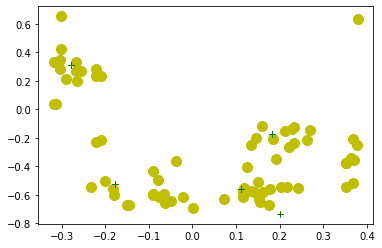

filename: HERE 2Dhist_20210225-112750.png
filename: HERE 3D_20210225-112750.png
filename: HERE hist_20210225-112750.png
filename: HERE HSW_2021_02_25__09_58_23__87min_37sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_25__09_58_23__87min_37sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_25__09_58_23__87min_37sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_25__09_58_23__87min_37sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_03_03__19_35_41__45min_13sec__hsamp_64ch_20000sps.bin
filename: HERE HSW_2021_03_03__19_35_41__45min_13sec__hsamp_64ch_20000sps.dat
filename: HERE HSW_2021_03_03__19_35_41__45min_13sec__hsamp_64ch_20000sps.xml~
filename: HERE HSW_2021_03_03__19_35_41__45min_13sec__hsamp_64ch_20000sps.xml
filename: HERE HSW_2021_03_03__19_35_41__45min_13sec__hsamp_64ch_20000sps.lfp
filename: HERE HSW_2021_03_03__19_35_41__45min_13sec__hsamp_64ch_20000sps.fil
filename: HERE HSW_2021_03_03__19_35_41__45min_13sec__hsamp_64ch_20000sps.fet.2
filename: HERE HSW_

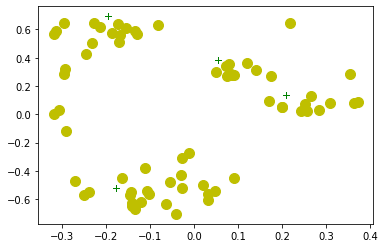

filename: HERE 2Dhist_20210303-185805.png
filename: HERE 3D_20210303-185805.png
filename: HERE hist_20210303-185805.png
filename: HERE HSW_2021_03_08__19_18_38__31min_01sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_08__19_18_38__31min_01sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_08__19_18_38__31min_01sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_08__19_18_38__31min_01sec__hsamp_64ch_25000sps.nrs
filename: HERE Take 2021-03-08 07.18.25 PM.csv
filename: HERE vrr
filename: HERE FS04-20210308-191837.xlsx
filename: HERE beacons_20210308-191837.txt
beacons_20210308-191837.txt
 found!
filename: HERE beacon_entry_20210308-191837.txt
filename: HERE metadata_20210308-191837.txt
filename: HERE position_20210308-191837.txt
position_20210308-191837.txt
 found! 
Match found making rearing file


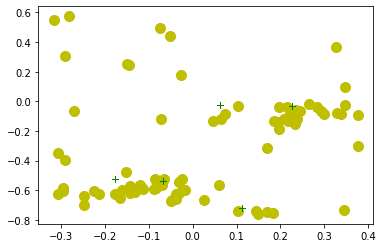

filename: HERE 2Dhist_20210308-191837.png
filename: HERE 3D_20210308-191837.png
filename: HERE hist_20210308-191837.png
filename: HERE HSW_2021_02_26__09_39_36__27min_11sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_26__09_39_36__27min_11sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_26__09_39_36__27min_11sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_26__09_39_36__27min_11sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_03_03__18_32_55__23min_30sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_03__18_32_55__23min_30sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_03__18_32_55__23min_30sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_08__18_19_54__51min_35sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_08__18_19_54__51min_35sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_08__18_19_54__51min_35sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_08__18_19_54__51min_35sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_202

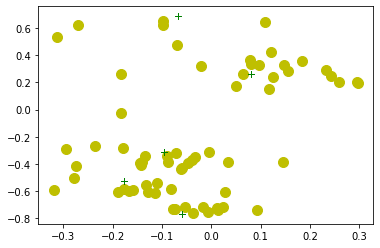

filename: HERE 2Dhist_20210401-115802.png
filename: HERE 3D_20210401-115802.png
filename: HERE hist_20210401-115802.png
filename: HERE HSW_2021_02_28__20_32_58__24min_37sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_02_28__20_32_58__24min_37sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_02_28__20_32_58__24min_37sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_28__20_32_58__24min_37sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_03_14__10_06_20__01min_18sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_05__12_39_17__40min_47sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_05__12_39_17__40min_47sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_05__12_39_17__40min_47sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_05__12_39_17__40min_47sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_03_09__18_28_05__22min_46sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_09__18_28_05__22min_46sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_202

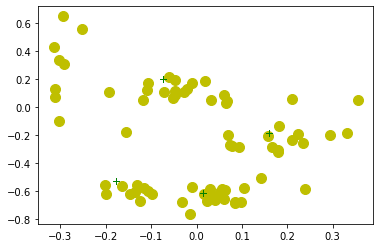

filename: HERE 2Dhist_20210309-182804.png
filename: HERE 3D_20210309-182804.png
filename: HERE hist_20210309-182804.png
filename: HERE HSW_2021_03_01__11_08_35__73min_26sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_01__11_08_35__73min_26sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_01__11_08_35__73min_26sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_01__11_08_35__73min_26sec__hsamp_64ch_25000sps.lfp
filename: HERE HSW_2021_03_01__11_08_35__73min_26sec__hsamp_64ch_25000sps.fil
filename: HERE HSW_2021_03_01__11_08_35__73min_26sec__hsamp_64ch_25000sps.fet.5
filename: HERE HSW_2021_03_01__11_08_35__73min_26sec__hsamp_64ch_25000sps.fet.6
filename: HERE HSW_2021_03_01__11_08_35__73min_26sec__hsamp_64ch_25000sps.clu.1
filename: HERE HSW_2021_03_01__11_08_35__73min_26sec__hsamp_64ch_25000sps.clu.2
filename: HERE HSW_2021_03_01__11_08_35__73min_26sec__hsamp_64ch_25000sps.clu.3
filename: HERE HSW_2021_03_01__11_08_35__73min_26sec__hsamp_64ch_25000sps.clu.4
filename: 

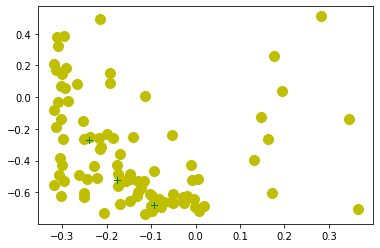

filename: HERE HSW_2021_03_02__09_33_41__14min_58sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_02__09_33_41__14min_58sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_02__09_33_41__14min_58sec__hsamp_64ch_25000sps.xml
filename: HERE Take 2021-03-02 09.32.29 AM.csv
filename: HERE vrr
filename: HERE HSW_2021_03_08__19_50_20__36min_21sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_08__19_50_20__36min_21sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_08__19_50_20__36min_21sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_08__19_50_20__36min_21sec__hsamp_64ch_25000sps.lfp
filename: HERE HSW_2021_03_08__19_50_20__36min_21sec__hsamp_64ch_25000sps.fil
filename: HERE HSW_2021_03_08__19_50_20__36min_21sec__hsamp_64ch_25000sps.fet.5
filename: HERE HSW_2021_03_08__19_50_20__36min_21sec__hsamp_64ch_25000sps.fet.6
filename: HERE HSW_2021_03_08__19_50_20__36min_21sec__hsamp_64ch_25000sps.clu.1
filename: HERE HSW_2021_03_08__19_50_20__36min_21sec__hsamp_64ch_25000

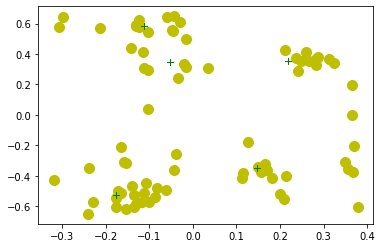

filename: HERE HSW_2021_03_22__20_25_03__30min_44sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_22__20_25_03__30min_44sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_22__20_25_03__30min_44sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_22__20_25_03__30min_44sec__hsamp_64ch_25000sps.lfp
filename: HERE HSW_2021_03_22__20_25_03__30min_44sec__hsamp_64ch_25000sps.fil
filename: HERE HSW_2021_03_22__20_25_03__30min_44sec__hsamp_64ch_25000sps.fet.5
filename: HERE HSW_2021_03_22__20_25_03__30min_44sec__hsamp_64ch_25000sps.fet.6
filename: HERE HSW_2021_03_22__20_25_03__30min_44sec__hsamp_64ch_25000sps.clu.1
filename: HERE HSW_2021_03_22__20_25_03__30min_44sec__hsamp_64ch_25000sps.clu.2
filename: HERE HSW_2021_03_22__20_25_03__30min_44sec__hsamp_64ch_25000sps.clu.3
filename: HERE HSW_2021_03_22__20_25_03__30min_44sec__hsamp_64ch_25000sps.clu.4
filename: HERE HSW_2021_03_22__20_25_03__30min_44sec__hsamp_64ch_25000sps.clu.5
filename: HERE HSW_2021_03_22__20_25_03__30min_44s

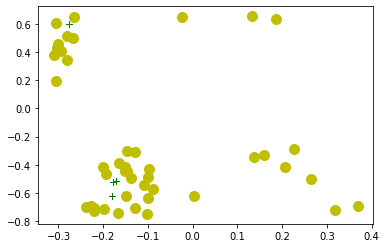

filename: HERE 2Dhist_20210322-202458.png
filename: HERE 3D_20210322-202458.png
filename: HERE hist_20210322-202458.png
filename: HERE HSW_2021_03_11__08_39_01__54min_16sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_11__08_39_01__54min_16sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_11__08_39_01__54min_16sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_11__08_39_01__54min_16sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_03_11__09_34_55__31min_19sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_11__09_34_55__31min_19sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_11__09_34_55__31min_19sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_11__09_34_55__31min_19sec__hsamp_64ch_25000sps.nrs
filename: HERE Video 110.wmv
filename: HERE Take 2021-03-11 09.33.27 AM.csv
filename: HERE vrr
filename: HERE FS04-20210311-093454.xlsx
filename: HERE beacons_20210311-093454.txt
beacons_20210311-093454.txt
 found!
filename: HERE beacon_entry_20210311-0934

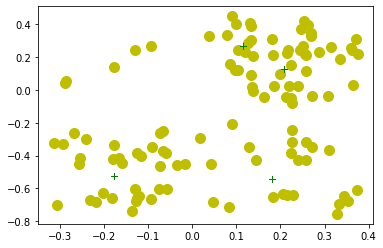

filename: HERE 2Dhist_20210311-093454.png
filename: HERE 3D_20210311-093454.png
filename: HERE hist_20210311-093454.png
filename: HERE HSW_2021_03_26__20_46_13__31min_07sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_26__20_46_13__31min_07sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_26__20_46_13__31min_07sec__hsamp_64ch_25000sps.xml
filename: HERE Take 2021-03-26 08.45.18 PM.csv
filename: HERE vrr
filename: HERE FS04-20210326-204600.xlsx
filename: HERE 2Dhist_20210326-204600.png
filename: HERE 3D_20210326-204600.png
filename: HERE hist_20210326-204600.png
filename: HERE beacons_20210326-204600.txt
beacons_20210326-204600.txt
 found!
filename: HERE beacon_entry_20210326-204600.txt
filename: HERE metadata_20210326-204600.txt
filename: HERE position_20210326-204600.txt
position_20210326-204600.txt
 found! 
Match found making rearing file


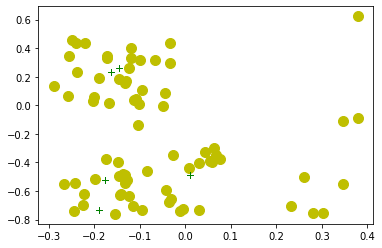

filename: HERE HSW_2021_03_17__11_41_05__34min_19sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_17__11_41_05__34min_19sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_17__11_41_05__34min_19sec__hsamp_64ch_25000sps.xml
filename: HERE Take 2021-03-17 11.40.45 AM.csv
filename: HERE vrr
filename: HERE FS04-20210317-114106.xlsx
filename: HERE beacons_20210317-114106.txt
beacons_20210317-114106.txt
 found!
filename: HERE beacon_entry_20210317-114106.txt
filename: HERE metadata_20210317-114106.txt
filename: HERE position_20210317-114106.txt
position_20210317-114106.txt
 found! 
Match found making rearing file


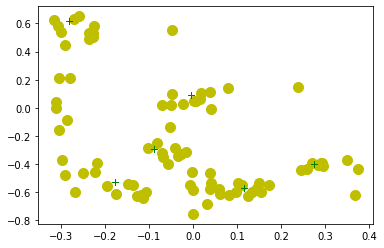

filename: HERE 2Dhist_20210317-114106.png
filename: HERE 3D_20210317-114106.png
filename: HERE hist_20210317-114106.png
filename: HERE HSW_2021_03_26__21_22_21__42min_14sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_26__21_22_21__42min_14sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_26__21_22_21__42min_14sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_16__15_57_05__56min_57sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_16__15_57_05__56min_57sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_16__15_57_05__56min_57sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_16__15_57_05__56min_57sec__hsamp_64ch_25000sps.lfp
filename: HERE HSW_2021_03_16__15_57_05__56min_57sec__hsamp_64ch_25000sps.fil
filename: HERE HSW_2021_03_16__15_57_05__56min_57sec__hsamp_64ch_25000sps.fet.5
filename: HERE HSW_2021_03_16__15_57_05__56min_57sec__hsamp_64ch_25000sps.fet.6
filename: HERE HSW_2021_03_16__15_57_05__56min_57sec__hsamp_64ch_25000sps.clu.1
filename: HERE H

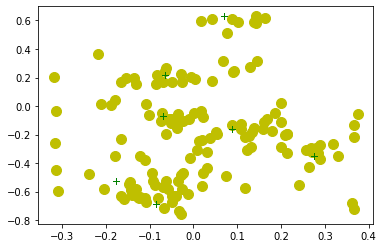

filename: HERE 2Dhist_20210316-163508.png
filename: HERE 3D_20210316-163508.png
filename: HERE hist_20210316-163508.png
filename: HERE 2Dhist_20210316-155817.png
filename: HERE 3D_20210316-155817.png
filename: HERE hist_20210316-155817.png
filename: HERE beacon_entry_20210316-163508.txt
filename: HERE metadata_20210316-163508.txt
filename: HERE position_20210316-163508.txt
position_20210316-163508.txt
 found! 
bad match
filename: HERE HSW_2021_03_23__20_39_15__17min_24sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_23__20_39_15__17min_24sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_23__20_39_15__17min_24sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_11__17_40_03__30min_54sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_11__17_40_03__30min_54sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_11__17_40_03__30min_54sec__hsamp_64ch_25000sps.xml
filename: HERE Take 2021-03-11 05.39.39 PM.csv
filename: HERE vrr
filename: HERE FS04-20210311-174007.xlsx
f

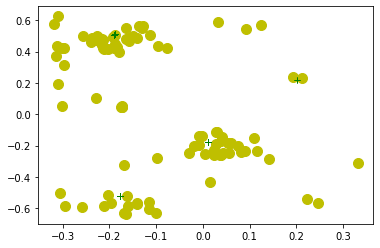

filename: HERE HSW_2021_03_11__18_11_00__20min_20sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_11__18_11_00__20min_20sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_11__18_11_00__20min_20sec__hsamp_64ch_25000sps.xml
filename: HERE Take 2021-03-11 06.10.46 PM.csv
filename: HERE vrr
filename: HERE beacon_entry_20210311-181116.txt
filename: HERE metadata_20210311-181116.txt
filename: HERE position_20210311-181116.txt
position_20210311-181116.txt
 found! 
bad match
filename: HERE 2Dhist_20210311-181116.png
filename: HERE 3D_20210311-181116.png
filename: HERE hist_20210311-181116.png
filename: HERE HSW_2021_03_12__12_37_04__06min_59sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_12__12_37_04__06min_59sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_12__12_37_04__06min_59sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_12__12_37_04__06min_59sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_03_12__12_44_04__10min_41sec__hsamp_64ch_25000sps.bin
filena

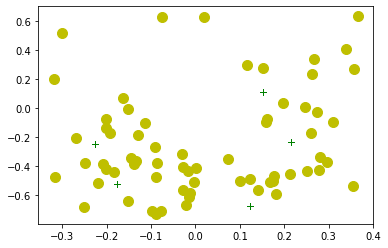

filename: HERE 2Dhist_20210318-093323.png
filename: HERE 3D_20210318-093323.png
filename: HERE hist_20210318-093323.png
filename: HERE HSW_2021_03_12__12_55_39__37min_16sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_12__12_55_39__37min_16sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_12__12_55_39__37min_16sec__hsamp_64ch_25000sps.xml
filename: HERE Take 2021-03-12 12.54.27 AM.csv
filename: HERE vrr
filename: HERE FS04-20210312-125536.xlsx
filename: HERE 2Dhist_20210312-125536.png
filename: HERE 3D_20210312-125536.png
filename: HERE hist_20210312-125536.png
filename: HERE beacons_20210312-125536.txt
beacons_20210312-125536.txt
 found!
filename: HERE beacon_entry_20210312-125536.txt
filename: HERE metadata_20210312-125536.txt
filename: HERE position_20210312-125536.txt
position_20210312-125536.txt
 found! 
Match found making rearing file


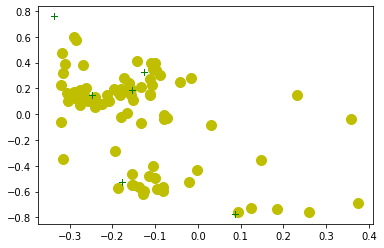

filename: HERE HSW_2021_03_23__19_40_13__22min_10sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_23__19_40_13__22min_10sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_23__19_40_13__22min_10sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_12__17_31_52__38min_21sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_12__17_31_52__38min_21sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_12__17_31_52__38min_21sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_12__17_31_52__38min_21sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_03_29__18_22_44__53min_11sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_29__18_22_44__53min_11sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_29__18_22_44__53min_11sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_29__18_22_44__53min_11sec__hsamp_64ch_25000sps.nrs
filename: HERE Take 2021-03-29 06.22.33 PM.csv
filename: HERE vrr
filename: HERE FS04-20210329-182246.xlsx
filename: HERE beacons_20210329-182

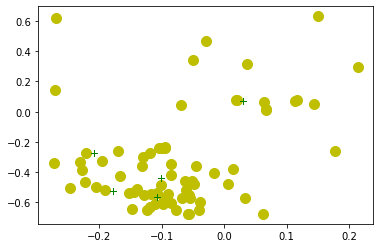

filename: HERE 2Dhist_20210329-182246.png
filename: HERE 3D_20210329-182246.png
filename: HERE hist_20210329-182246.png
filename: HERE 2Dhist_20210329-185305.png
filename: HERE 3D_20210329-185305.png
filename: HERE hist_20210329-185305.png
filename: HERE beacon_entry_20210329-185305.txt
filename: HERE metadata_20210329-185305.txt
filename: HERE position_20210329-185305.txt
position_20210329-185305.txt
 found! 
bad match
filename: HERE HSW_2021_03_12__18_14_32__41min_21sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_12__18_14_32__41min_21sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_12__18_14_32__41min_21sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_12__18_14_32__41min_21sec__hsamp_64ch_25000sps.nrs
filename: HERE Take 2021-03-12 06.14.10 PM.csv
filename: HERE vrr
filename: HERE FS04-20210312-181429.xlsx
filename: HERE beacons_20210312-181429.txt
beacons_20210312-181429.txt
 found!
filename: HERE beacon_entry_20210312-181429.txt
filename: HERE metadata_202103

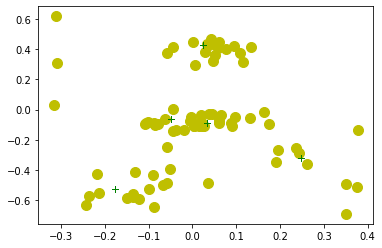

filename: HERE 2Dhist_20210312-181429.png
filename: HERE 3D_20210312-181429.png
filename: HERE hist_20210312-181429.png
filename: HERE 2Dhist_20210312-184457.png
filename: HERE 3D_20210312-184457.png
filename: HERE hist_20210312-184457.png
filename: HERE beacon_entry_20210312-184457.txt
filename: HERE metadata_20210312-184457.txt
filename: HERE position_20210312-184457.txt
position_20210312-184457.txt
 found! 
bad match
filename: HERE HSW_2021_03_31__09_54_12__30min_58sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_31__09_54_12__30min_58sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_31__09_54_12__30min_58sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_31__09_54_12__30min_58sec__hsamp_64ch_25000sps.lfp
filename: HERE HSW_2021_03_31__09_54_12__30min_58sec__hsamp_64ch_25000sps.fil
filename: HERE HSW_2021_03_31__09_54_12__30min_58sec__hsamp_64ch_25000sps.fet.5
filename: HERE HSW_2021_03_31__09_54_12__30min_58sec__hsamp_64ch_25000sps.fet.6
filename: HERE HSW_2021_03

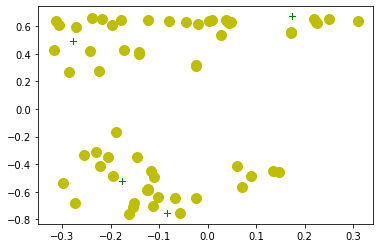

filename: HERE 2Dhist_20210331-095408.png
filename: HERE 3D_20210331-095408.png
filename: HERE hist_20210331-095408.png
filename: HERE HSW_2021_03_16__14_53_21__02min_22sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_16__14_53_21__02min_22sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_16__14_53_21__02min_22sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_17__09_33_11__124min_53sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_17__09_33_11__124min_53sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_17__09_33_11__124min_53sec__hsamp_64ch_25000sps.xml
filename: HERE Take 2021-03-17 09.28.53 AM.csv
filename: HERE vrr
filename: HERE HSW_2021_03_18__08_42_09__46min_40sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_18__08_42_09__46min_40sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_18__08_42_09__46min_40sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_14__09_42_18__01min_08sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_14__

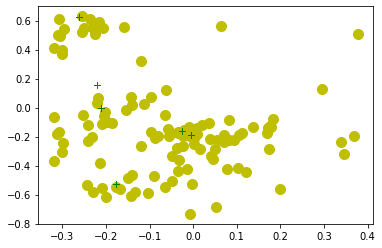

filename: HERE beacon_entry_20210318-113314.txt
filename: HERE metadata_20210318-113314.txt
filename: HERE position_20210318-113314.txt
position_20210318-113314.txt
 found! 
bad match
filename: HERE 2Dhist_20210318-113314.png
filename: HERE 3D_20210318-113314.png
filename: HERE hist_20210318-113314.png
filename: HERE HSW_2021_03_29__17_29_01__29min_47sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_29__17_29_01__29min_47sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_29__17_29_01__29min_47sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_14__09_43_34__01min_11sec__hsamp_64ch_714sps.bin
filename: HERE HSW_2021_03_14__09_43_34__01min_11sec__hsamp_64ch_714sps.dat
filename: HERE HSW_2021_03_14__09_43_34__01min_11sec__hsamp_64ch_714sps.xml
filename: HERE HSW_2021_03_14__09_43_34__01min_11sec__hsamp_64ch_714sps.nrs
filename: HERE HSW_2021_03_30__17_07_13__14min_21sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_30__17_07_13__14min_21sec__hsamp_64ch_25000sps.dat
fi

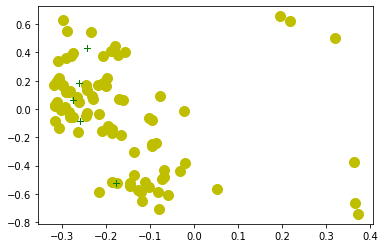

filename: HERE 2Dhist_20210315-102910.png
filename: HERE 3D_20210315-102910.png
filename: HERE hist_20210315-102910.png
filename: HERE HSW_2021_03_15__11_06_48__32min_31sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_15__11_06_48__32min_31sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_15__11_06_48__32min_31sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_16__10_43_10__31min_10sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_16__10_43_10__31min_10sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_16__10_43_10__31min_10sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_16__10_43_10__31min_10sec__hsamp_64ch_25000sps.nrs
filename: HERE Take 2021-03-16 10.42.45 AM.csv
filename: HERE vrr
filename: HERE FS04-20210316-104312.xlsx
filename: HERE 2Dhist_20210316-104312.png
filename: HERE 3D_20210316-104312.png
filename: HERE hist_20210316-104312.png
filename: HERE beacons_20210316-104312.txt
beacons_20210316-104312.txt
 found!
filename: HERE beacon_entry_

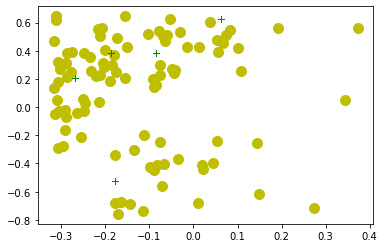

filename: HERE HSW_2021_03_16__14_56_48__00min_39sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_16__14_56_48__00min_39sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_16__14_56_48__00min_39sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_18__12_05_31__38min_08sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_18__12_05_31__38min_08sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_18__12_05_31__38min_08sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_30__14_23_01__43min_54sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_30__14_23_01__43min_54sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_30__14_23_01__43min_54sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_14__10_09_47__00min_41sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_14__10_09_47__00min_41sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_14__10_09_47__00min_41sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_14__10_09_47__00min_41sec__hsamp_64ch

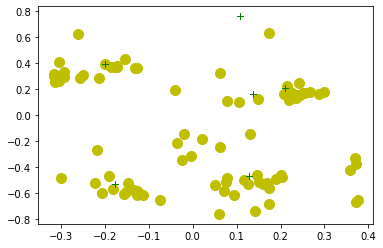

filename: HERE 2Dhist_20210317-152846.png
filename: HERE 3D_20210317-152846.png
filename: HERE hist_20210317-152846.png
filename: HERE 2Dhist_20210317-155920.png
filename: HERE 3D_20210317-155920.png
filename: HERE hist_20210317-155920.png
filename: HERE beacon_entry_20210317-155920.txt
filename: HERE metadata_20210317-155920.txt
filename: HERE position_20210317-155920.txt
position_20210317-155920.txt
 found! 
bad match
filename: HERE HSW_2021_03_19__20_28_16__17min_06sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_19__20_28_16__17min_06sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_19__20_28_16__17min_06sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_02_20__15_38_03__01min_23sec__hsamp_64ch_25000sps.bin
filename: HERE Take 2020-02-20 03.37.07 PM.csv
filename: HERE vrr
filename: HERE HSW_2021_03_16__09_47_46__46min_21sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_16__09_47_46__46min_21sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_16__09_47_46__4

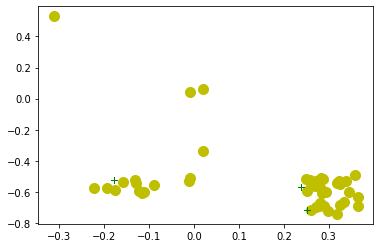

filename: HERE HSW_2021_04_09__16_15_36__67min_47sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_09__16_15_36__67min_47sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_09__16_15_36__67min_47sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_09__16_15_36__67min_47sec__hsamp_64ch_25000sps.lfp
filename: HERE HSW_2021_04_09__16_15_36__67min_47sec__hsamp_64ch_25000sps.fil
filename: HERE HSW_2021_04_09__16_15_36__67min_47sec__hsamp_64ch_25000sps.fet.5
filename: HERE HSW_2021_04_09__16_15_36__67min_47sec__hsamp_64ch_25000sps.fet.6
filename: HERE HSW_2021_04_09__16_15_36__67min_47sec__hsamp_64ch_25000sps.clu.1
filename: HERE HSW_2021_04_09__16_15_36__67min_47sec__hsamp_64ch_25000sps.clu.2
filename: HERE HSW_2021_04_09__16_15_36__67min_47sec__hsamp_64ch_25000sps.clu.3
filename: HERE HSW_2021_04_09__16_15_36__67min_47sec__hsamp_64ch_25000sps.clu.4
filename: HERE HSW_2021_04_09__16_15_36__67min_47sec__hsamp_64ch_25000sps.clu.5
filename: HERE HSW_2021_04_09__16_15_36__67min_47s

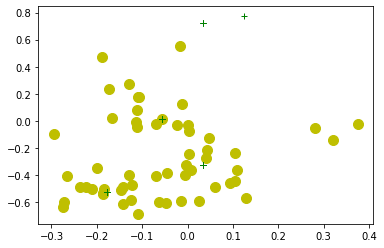

filename: HERE 2Dhist_20210406-151618.png
filename: HERE 3D_20210406-151618.png
filename: HERE hist_20210406-151618.png
filename: HERE beacon_entry_20210406-154635.txt
filename: HERE metadata_20210406-154635.txt
filename: HERE position_20210406-154635.txt
position_20210406-154635.txt
 found! 
bad match
filename: HERE 2Dhist_20210406-154635.png
filename: HERE 3D_20210406-154635.png
filename: HERE hist_20210406-154635.png
filename: HERE HSW_2021_04_07__13_01_54__19min_32sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_07__13_01_54__19min_32sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_07__13_01_54__19min_32sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_07__13_01_54__19min_32sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_04_09__11_05_37__51min_07sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_09__11_05_37__51min_07sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_09__11_05_37__51min_07sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_30_

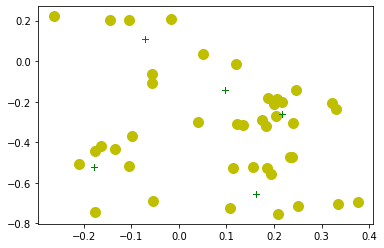

filename: HERE HSW_2021_04_09__17_23_57__25min_39sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_09__17_23_57__25min_39sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_09__17_23_57__25min_39sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_30__15_50_09__36min_17sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_30__15_50_09__36min_17sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_30__15_50_09__36min_17sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_12__11_27_19__20min_13sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_12__11_27_19__20min_13sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_12__11_27_19__20min_13sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_30__16_31_48__34min_01sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_30__16_31_48__34min_01sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_30__16_31_48__34min_01sec__hsamp_64ch_25000sps.xml
filename: HERE Take 2021-03-30 04.30.04 PM.csv
filename: HERE vr

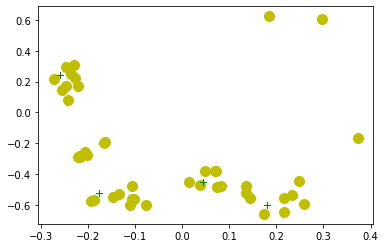

filename: HERE 2Dhist_20210330-163153.png
filename: HERE 3D_20210330-163153.png
filename: HERE hist_20210330-163153.png
filename: HERE HSW_2021_04_09__15_47_24__26min_11sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_09__15_47_24__26min_11sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_09__15_47_24__26min_11sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_31__09_19_29__19min_00sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_31__09_19_29__19min_00sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_31__09_19_29__19min_00sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_31__09_38_29__12min_43sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_31__09_38_29__12min_43sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_31__09_38_29__12min_43sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_31__10_35_57__28min_02sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_31__10_35_57__28min_02sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_202

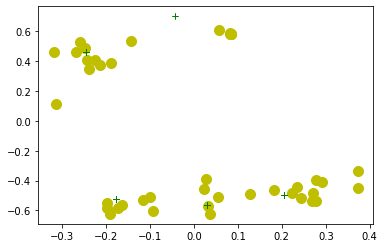

filename: HERE HSW_2021_04_12__09_01_01__12min_03sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_12__09_01_01__12min_03sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_12__09_01_01__12min_03sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_12__09_01_01__12min_03sec__hsamp_64ch_25000sps.lfp
filename: HERE HSW_2021_04_12__09_01_01__12min_03sec__hsamp_64ch_25000sps.fil
filename: HERE HSW_2021_04_12__09_01_01__12min_03sec__hsamp_64ch_25000sps.fet.5
filename: HERE HSW_2021_04_12__09_01_01__12min_03sec__hsamp_64ch_25000sps.fet.6
filename: HERE HSW_2021_04_12__09_01_01__12min_03sec__hsamp_64ch_25000sps.clu.1
filename: HERE HSW_2021_04_12__09_01_01__12min_03sec__hsamp_64ch_25000sps.clu.2
filename: HERE HSW_2021_04_12__09_01_01__12min_03sec__hsamp_64ch_25000sps.clu.3
filename: HERE HSW_2021_04_12__09_01_01__12min_03sec__hsamp_64ch_25000sps.clu.4
filename: HERE HSW_2021_04_12__09_01_01__12min_03sec__hsamp_64ch_25000sps.clu.5
filename: HERE HSW_2021_04_12__09_01_01__12min_03s

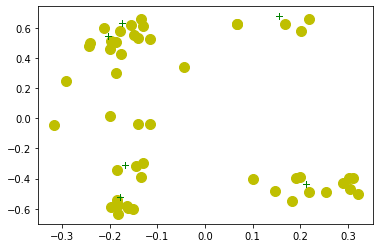

filename: HERE 2Dhist_20210407-142855.png
filename: HERE 3D_20210407-142855.png
filename: HERE hist_20210407-142855.png
filename: HERE beacon_entry_20210407-142855.txt
filename: HERE metadata_20210407-142855.txt
filename: HERE position_20210407-142855.txt
position_20210407-142855.txt
 found! 
bad match
filename: HERE HSW_2021_04_08__09_01_52__67min_55sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_08__09_01_52__67min_55sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_08__09_01_52__67min_55sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_07__12_16_35__44min_41sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_07__12_16_35__44min_41sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_07__12_16_35__44min_41sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_07__12_16_35__44min_41sec__hsamp_64ch_25000sps.lfp
filename: HERE HSW_2021_04_07__12_16_35__44min_41sec__hsamp_64ch_25000sps.fil
filename: HERE HSW_2021_04_07__12_16_35__44min_41sec__hsamp_64ch_25000sp

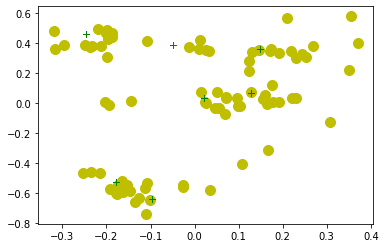

filename: HERE HSW_2021_04_08__08_57_17__04min_31sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_08__08_57_17__04min_31sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_08__08_57_17__04min_31sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_08__08_57_17__04min_31sec__hsamp_64ch_25000sps.lfp
filename: HERE HSW_2021_04_08__08_57_17__04min_31sec__hsamp_64ch_25000sps.fil
filename: HERE HSW_2021_04_08__08_57_17__04min_31sec__hsamp_64ch_25000sps.fet.5
filename: HERE HSW_2021_04_08__08_57_17__04min_31sec__hsamp_64ch_25000sps.fet.6
filename: HERE HSW_2021_04_08__08_57_17__04min_31sec__hsamp_64ch_25000sps.clu.1
filename: HERE HSW_2021_04_08__08_57_17__04min_31sec__hsamp_64ch_25000sps.clu.2
filename: HERE HSW_2021_04_08__08_57_17__04min_31sec__hsamp_64ch_25000sps.clu.3
filename: HERE HSW_2021_04_08__08_57_17__04min_31sec__hsamp_64ch_25000sps.clu.4
filename: HERE HSW_2021_04_08__08_57_17__04min_31sec__hsamp_64ch_25000sps.clu.5
filename: HERE HSW_2021_04_08__08_57_17__04min_31s

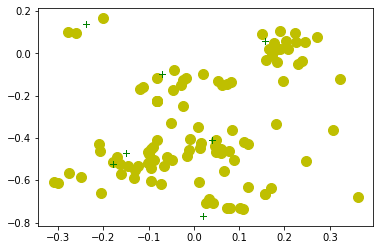

filename: HERE 2Dhist_20210401-153548.png
filename: HERE 3D_20210401-153548.png
filename: HERE hist_20210401-153548.png
filename: HERE 2Dhist_20210401-145728.png
filename: HERE 3D_20210401-145728.png
filename: HERE hist_20210401-145728.png
filename: HERE beacon_entry_20210401-153548.txt
filename: HERE metadata_20210401-153548.txt
filename: HERE position_20210401-153548.txt
position_20210401-153548.txt
 found! 
bad match
filename: HERE HSW_2021_04_12__09_15_59__59min_08sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_12__09_15_59__59min_08sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_12__09_15_59__59min_08sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_12__09_15_59__59min_08sec__hsamp_64ch_25000sps.lfp
filename: HERE HSW_2021_04_12__09_15_59__59min_08sec__hsamp_64ch_25000sps.fil
filename: HERE HSW_2021_04_12__09_15_59__59min_08sec__hsamp_64ch_25000sps.fet.5
filename: HERE HSW_2021_04_12__09_15_59__59min_08sec__hsamp_64ch_25000sps.fet.6
filename: HERE HSW_2021_04

Match found making rearing file


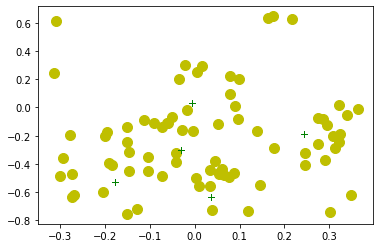

filename: HERE HSW_2021_04_02__11_15_45__19min_57sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_02__11_15_45__19min_57sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_02__11_15_45__19min_57sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_12__10_22_34__64min_01sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_12__10_22_34__64min_01sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_12__10_22_34__64min_01sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_12__10_22_34__64min_01sec__hsamp_64ch_25000sps.lfp
filename: HERE HSW_2021_04_12__10_22_34__64min_01sec__hsamp_64ch_25000sps.fil
filename: HERE HSW_2021_04_12__10_22_34__64min_01sec__hsamp_64ch_25000sps.fet.5
filename: HERE HSW_2021_04_12__10_22_34__64min_01sec__hsamp_64ch_25000sps.fet.6
filename: HERE HSW_2021_04_12__10_22_34__64min_01sec__hsamp_64ch_25000sps.clu.1
filename: HERE HSW_2021_04_12__10_22_34__64min_01sec__hsamp_64ch_25000sps.clu.2
filename: HERE HSW_2021_04_12__10_22_34__64min_01sec__hs

bad match
filename: HERE HSW_2021_04_06__11_46_20__36min_28sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_06__11_46_20__36min_28sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_06__11_46_20__36min_28sec__hsamp_64ch_25000sps.xml
filename: HERE Take 2021-04-06 11.45.26 AM.csv
filename: HERE vrr
filename: HERE FS04-20210406-114628.xlsx
filename: HERE 2Dhist_20210406-114628.png
filename: HERE 3D_20210406-114628.png
filename: HERE hist_20210406-114628.png
filename: HERE beacons_20210406-114628.txt
beacons_20210406-114628.txt
 found!
filename: HERE beacon_entry_20210406-114628.txt
filename: HERE metadata_20210406-114628.txt
filename: HERE position_20210406-114628.txt
position_20210406-114628.txt
 found! 
Match found making rearing file


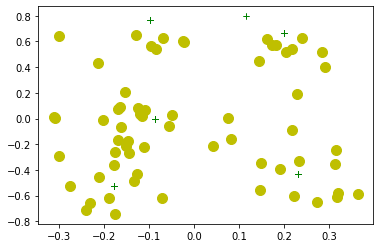

filename: HERE HSW_2021_04_06__13_18_36__44min_28sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_06__13_18_36__44min_28sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_06__13_18_36__44min_28sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_07__13_21_26__32min_42sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_07__13_21_26__32min_42sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_07__13_21_26__32min_42sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_08__10_10_58__70min_14sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_08__10_10_58__70min_14sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_08__10_10_58__70min_14sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_08__10_10_58__70min_14sec__hsamp_64ch_25000sps.lfp
filename: HERE HSW_2021_04_08__10_10_58__70min_14sec__hsamp_64ch_25000sps.fil
filename: HERE HSW_2021_04_08__10_10_58__70min_14sec__hsamp_64ch_25000sps.fet.5
filename: HERE HSW_2021_04_08__10_10_58__70min_14sec__hsamp_64

bad match
filename: HERE HSW_2021_04_12__15_58_00__46min_22sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_12__15_58_00__46min_22sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_12__15_58_00__46min_22sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_12__16_44_19__52min_14sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_12__16_44_19__52min_14sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_12__16_44_19__52min_14sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_15__09_57_11__68min_39sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_15__09_57_11__68min_39sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_15__09_57_11__68min_39sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_15__09_57_11__68min_39sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_04_16__14_31_03__11min_19sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_16__14_31_03__11min_19sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_16__14_31_03__11min_19sec__

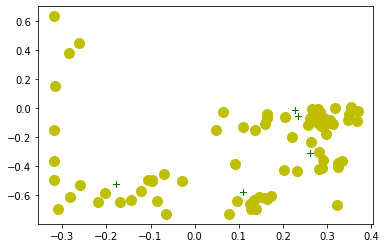

filename: HERE HSW_2021_03_12__09_26_31__25min_15sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_12__09_26_31__25min_15sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_12__09_26_31__25min_15sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_03_15__15_51_50__48min_26sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_15__15_51_50__48min_26sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_15__15_51_50__48min_26sec__hsamp_64ch_25000sps.xml
filename: HERE Take 2021-03-15 03.46.04 PM.csv
filename: HERE vrr
filename: HERE FS04-20210315-155158.xlsx
filename: HERE 2Dhist_20210315-155158.png
filename: HERE 3D_20210315-155158.png
filename: HERE hist_20210315-155158.png
filename: HERE beacons_20210315-155158.txt
beacons_20210315-155158.txt
 found!
filename: HERE beacon_entry_20210315-155158.txt
filename: HERE metadata_20210315-155158.txt
filename: HERE position_20210315-155158.txt
position_20210315-155158.txt
 found! 
Match found making rearing file


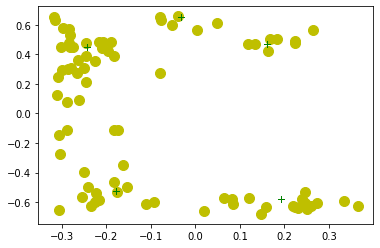

filename: HERE beacon_entry_20210315-162227.txt
filename: HERE metadata_20210315-162227.txt
filename: HERE position_20210315-162227.txt
position_20210315-162227.txt
 found! 
bad match
filename: HERE 2Dhist_20210315-162227.png
filename: HERE 3D_20210315-162227.png
filename: HERE hist_20210315-162227.png
filename: HERE HSW_2021_03_15__16_46_48__53min_13sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_03_15__16_46_48__53min_13sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_03_15__16_46_48__53min_13sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_13__10_47_13__60min_03sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_13__10_47_13__60min_03sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_13__10_47_13__60min_03sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_16__14_46_56__52min_01sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_16__14_46_56__52min_01sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_16__14_46_56__52min_01sec__hsamp_64ch_25000sp

filename: HERE HSW_2021_04_20__13_44_52__80min_14sec__hsamp_64ch_25000sps.res.3
filename: HERE HSW_2021_04_20__13_44_52__80min_14sec__hsamp_64ch_25000sps.spk.3
filename: HERE HSW_2021_04_20__13_44_52__80min_14sec__hsamp_64ch_25000sps.res.4
filename: HERE HSW_2021_04_20__13_44_52__80min_14sec__hsamp_64ch_25000sps.spk.4
filename: HERE HSW_2021_04_20__13_44_52__80min_14sec__hsamp_64ch_25000sps.res.5
filename: HERE HSW_2021_04_20__13_44_52__80min_14sec__hsamp_64ch_25000sps.spk.5
filename: HERE HSW_2021_04_20__13_44_52__80min_14sec__hsamp_64ch_25000sps.res.6
filename: HERE HSW_2021_04_20__13_44_52__80min_14sec__hsamp_64ch_25000sps.spk.6
filename: HERE HSW_2021_04_20__13_44_52__80min_14sec__hsamp_64ch_25000sps.fet.1
filename: HERE HSW_2021_04_20__13_44_52__80min_14sec__hsamp_64ch_25000sps.fet.2
filename: HERE HSW_2021_04_20__13_44_52__80min_14sec__hsamp_64ch_25000sps.fet.4
filename: HERE HSW_2021_04_20__13_44_52__80min_14sec__hsamp_64ch_25000sps.fet.5
filename: HERE HSW_2021_04_20__13_44_52_

bad match
filename: HERE HSW_2021_04_14__14_16_47__62min_55sec__hsamp_64ch_25000sps.clu.1
filename: HERE HSW_2021_04_14__14_16_47__62min_55sec__hsamp_64ch_25000sps.clu.2
filename: HERE HSW_2021_04_14__14_16_47__62min_55sec__hsamp_64ch_25000sps.clu.3
filename: HERE HSW_2021_04_14__14_16_47__62min_55sec__hsamp_64ch_25000sps.clu.4
filename: HERE HSW_2021_04_14__14_16_47__62min_55sec__hsamp_64ch_25000sps.clu.5
filename: HERE HSW_2021_04_14__14_16_47__62min_55sec__hsamp_64ch_25000sps.clu.6
filename: HERE HSW_2021_04_14__15_22_17__43min_28sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_14__15_22_17__43min_28sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_14__15_22_17__43min_28sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_14__15_22_17__43min_28sec__hsamp_64ch_25000sps.nrs
filename: HERE HSW_2021_04_20__16_46_55__65min_02sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_20__16_46_55__65min_02sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_20__16_46_55__6

filename: HERE arena.traj
filename: HERE collisions.traj
filename: HERE external.traj
filename: HERE hotspots.traj
filename: HERE positions.traj
filename: HERE rewards.traj
filename: HERE vr_events.traj
filename: HERE VShiftA.mtl
filename: HERE VShiftA.obj
filename: HERE VShiftA_Fabian_prod.json
filename: HERE arena.traj
filename: HERE collisions.traj
filename: HERE external.traj
filename: HERE hotspots.traj
filename: HERE positions.traj
filename: HERE rewards.traj
filename: HERE tracking.avi
filename: HERE vr_events.traj
filename: HERE VShiftA.mtl
filename: HERE VShiftA.obj
filename: HERE VShiftA_Fabian_prod.json
filename: HERE arena.traj
filename: HERE collisions.traj
filename: HERE external.traj
filename: HERE hotspots.traj
filename: HERE positions.traj
filename: HERE rewards.traj
filename: HERE tracking.avi
filename: HERE vr_events.traj
filename: HERE VShiftA.mtl
filename: HERE VShiftA.obj
filename: HERE VShiftA_Fabian_prod.json
filename: HERE arena.traj
filename: HERE collisions.t

bad match
filename: HERE HSW_2021_04_21__17_03_20__39min_16sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_21__17_03_20__39min_16sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_21__17_03_20__39min_16sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_22__13_00_44__90min_43sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_22__13_00_44__90min_43sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_22__13_00_44__90min_43sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_21__20_08_25__15min_04sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_21__20_08_25__15min_04sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_21__20_08_25__15min_04sec__hsamp_64ch_25000sps.xml
filename: HERE Take 2021-04-21 08.08.21 PM.csv
filename: HERE vrr
filename: HERE HSW_2021_04_22__11_48_54__21min_39sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_22__11_48_54__21min_39sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_22__11_48_54__21min_39sec__hsamp_64ch_2

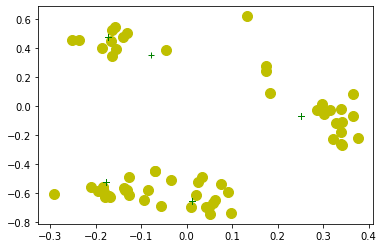

filename: HERE HSW_2021_04_21__20_03_41__03min_33sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_21__20_03_41__03min_33sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_21__20_03_41__03min_33sec__hsamp_64ch_25000sps.xml
filename: HERE Take 2021-04-21 08.03.39 PM.csv
filename: HERE vrr
filename: HERE HSW_2021_04_21__15_07_54__115min_34sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_21__15_07_54__115min_34sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_21__15_07_54__115min_34sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_22__12_24_42__29min_04sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_22__12_24_42__29min_04sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_22__12_24_42__29min_04sec__hsamp_64ch_25000sps.xml
filename: HERE FS04-20210422-122446.xlsx
filename: HERE beacons_20210422-122446.txt
beacons_20210422-122446.txt
 found!
filename: HERE beacon_entry_20210422-122446.txt
filename: HERE metadata_20210422-122446.txt
filename: HERE po

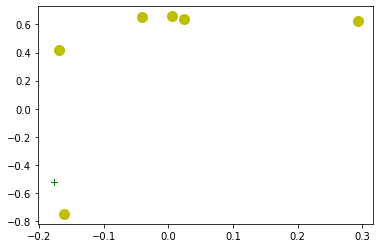

filename: HERE 2Dhist_20210422-122446.png
filename: HERE 3D_20210422-122446.png
filename: HERE hist_20210422-122446.png
filename: HERE HSW_2021_04_22__17_11_03__32min_38sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_22__17_11_03__32min_38sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_22__17_11_03__32min_38sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_19__15_16_02__31min_44sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_19__15_16_02__31min_44sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_19__15_16_02__31min_44sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_19__17_13_03__15min_15sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_19__17_13_03__15min_15sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_19__17_13_03__15min_15sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_17__13_02_41__37min_29sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_17__13_02_41__37min_29sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_202

bad match
filename: HERE HSW_2021_04_19__17_08_46__04min_09sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_19__17_08_46__04min_09sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_19__17_08_46__04min_09sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_19__09_03_04__90min_07sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_19__09_03_04__90min_07sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_19__09_03_04__90min_07sec__hsamp_64ch_25000sps.xml
filename: HERE HSW_2021_04_19__10_34_47__61min_22sec__hsamp_64ch_25000sps.bin
filename: HERE HSW_2021_04_19__10_34_47__61min_22sec__hsamp_64ch_25000sps.dat
filename: HERE HSW_2021_04_19__10_34_47__61min_22sec__hsamp_64ch_25000sps.xml
filename: HERE Take 2021-04-19 10.32.51 AM.csv
filename: HERE HSW_2021_04_19__10_34_47__61min_22sec__hsamp_64ch_25000sps.nrs
filename: HERE vrr
filename: HERE 2Dhist_20210419-105334.png
filename: HERE 3D_20210419-105334.png
filename: HERE hist_20210419-105334.png
filename: HERE beacon_en

In [104]:
import os 

how_many= 0 

substring = "BPositions_"
position = "position_2"
beacon = 'beacons'
#animal = 'C:/Users/Fabian/Desktop/Analysis/Round3_FS03_FS06/Data/FS04/'
animal = '//10.153.170.3/storage2/fabian/data/raw/FS04'
#FS04= '//10.153.170.3/storage2/fabian/Data/raw/FS04'    

rearing = pd.DataFrame()
for dirpath, dirnames, files in os.walk(animal, topdown=True):
    fullstring = dirpath
    for file_name in files:
        #print(f'Found directory: {dirpath}')
        #print(dirpath)
        print('filename: HERE '+file_name)
        fullstring = dirpath
        #dirpath = dirpath.replace("\","/")
        #print(dirpath)
        if beacon in file_name:
            print(file_name)
            print(" found!")
            beacons  = pd.read_csv(dirpath+'/'+file_name,sep=" ", header = None,engine='python')
            beacon_date = list(file_name)
        if position in file_name:
            print(file_name)
            print(" found! ")
            positions = pd.read_csv(dirpath+'/'+file_name,sep=" ", header=None,engine='python')
            positions_date= list(file_name)
            if beacon_date[-9:]==positions_date[-9:]:
                print ("Match found making rearing file")
                how_many += 1
                rearing_df=make_rearing_df(positions,beacons)
                plt.plot(rearing_df[1],rearing_df[2],'yo',ms=10)
                plt.plot(rearing_df[4],rearing_df[5],'g+')
                plt.show()
                if how_many<1.5:
                    rearing = rearing_df
                else:
                    rearing = rearing.append(rearing_df,ignore_index=True)
                #print(dirpath + '/'+ rename (file_name) +'.xlsx')
                #HSW_directory = dirpath.split(chr(92)+'B', 1)
                #print( HSW_directory[0])
            else: 
                print('bad match')

print('DataFrame made.')
            

print ('Matched %s files' %(how_many))

In [105]:
rearing.columns=["Time", "RatX","RatY", "RatZ","BeaconX", "BeaconY","Visibility" ]
writer = pd.ExcelWriter(processed +'FS04_rears.xlsx')
rearing.to_excel(writer)
writer.save()

### Create histogram of how far away from beacon when reared for all first  need to subtract differetn beacon location each time 

In [85]:
rearing

,0,1,2,3,4,5,6
0,1608550224.000,0.143,-0.157,0.624,-0.177,-0.524,1.000
1,1608550239.480,-0.058,-0.550,0.622,-0.177,-0.524,1.000
2,1608550253.090,-0.003,-0.743,0.622,-0.177,-0.524,1.000
3,1608550266.690,-0.203,-0.486,0.627,-0.177,-0.524,1.000
4,1608550267.890,-0.058,-0.512,0.622,-0.177,-0.524,1.000
5,1608550304.110,0.368,-0.439,0.622,-0.177,-0.524,1.000
6,1608550320.160,-0.075,-0.605,0.625,-0.177,-0.524,1.000
7,1608550353.550,-0.299,0.611,0.622,-0.177,-0.524,1.000
8,1608550376.100,-0.056,0.576,0.623,-0.177,-0.524,0.000
9,1608550382.510,-0.163,-0.649,0.622,-0.177,-0.524,0.000


#### First calculate distance

In [36]:
def calculate_Distance(x,y): 
        """Calculates distance given position"""
        travel=0
        for i in range(len(y)-1):
            dist = math.sqrt((x[0+i] - x[1+i])**2 + (y[0+i] - y[1+i])**2)
            travel+=dist

        return travel 

### Normalize position with respect to the beacon  check

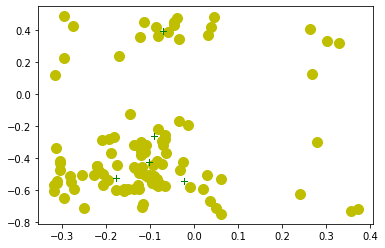

In [119]:
plt.plot(rr[1],rr[2],'yo',ms=10)
plt.plot(rr[4],rr[5],'g+')
plt.savefig('%srears_cut_with_beacons.png' %(figures), dpi = 200) 



### Histogram for all 

(array([2691.,  813.,  301.,  212.,  123.,  109.,   84.,   71.,   17.,
           6.]),
 array([0.0028795 , 0.16623563, 0.32959176, 0.49294789, 0.65630401,
        0.81966014, 0.98301627, 1.1463724 , 1.30972852, 1.47308465,
        1.63644078]),
 <a list of 10 Patch objects>)

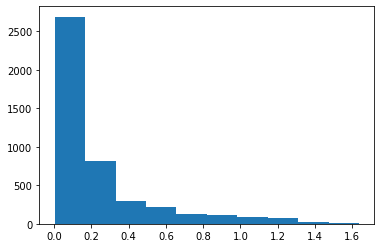

In [88]:
def get_rear_distance_from_beacon(df_rears_corrected):
    dist=[]
    for row in df_rears_corrected.iterrows():
        #print(row[1][1])
        #print(row[1][4])
        #print(row[1][2])
        #print(row[1][5])
        dist.append(math.sqrt((row[1][1] - row[1][4])**2 + (row[1][2] - row[1][5])**2))

    return dist 
plt.hist(get_rear_distance_from_beacon(rearing))

## Only for invisible succesfull

(array([24., 46., 36.,  3.,  8., 10.,  3.]),
 array([0.07, 0.09, 0.15, 0.3 , 0.4 , 0.5 , 1.  , 2.  ]),
 <a list of 7 Patch objects>)

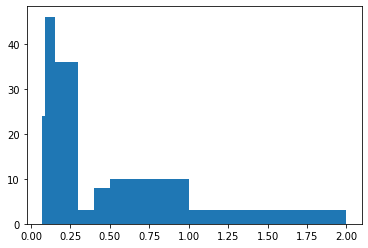

In [103]:
w = 3
invisible= get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==2])
#data=list(map(int, invisible))
#n = math.ceil((data.max() - data.min())/w)
plt.hist(invisible, bins=[0.07, 0.09, 0.15, .3, .40, .50, 1,2])

## For visible succesful

(array([1312.,  437.,  149.,   95.,   38.,   48.,   29.,   35.,   11.,
           5.]),
 array([0.0028795 , 0.15912272, 0.31536593, 0.47160915, 0.62785236,
        0.78409558, 0.94033879, 1.096582  , 1.25282522, 1.40906843,
        1.56531165]),
 <a list of 10 Patch objects>)

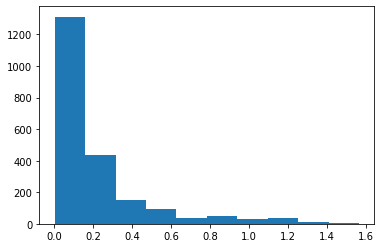

In [93]:
plt.hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==1]))

### For visible only 

(array([1257.,  341.,  177.,  114.,   75.,   57.,   51.,   39.,   34.,
          17.]),
 array([0.00187005, 0.14767753, 0.29348502, 0.43929251, 0.5851    ,
        0.73090749, 0.87671498, 1.02252247, 1.16832996, 1.31413744,
        1.45994493]),
 <a list of 10 Patch objects>)

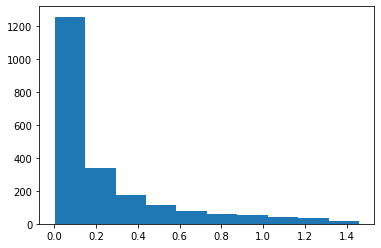

In [169]:
plt.hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==0]))

In [178]:
processed= 'C:/Users/Fabian/Desktop/Analysis/Round3_FS03_FS06/processed/'
rearing_FS04 = pd.read_excel(processed + 'FS04_rears.xlsx',index_col=0)
rearing_FS03 = pd.read_excel(processed + 'FS03_rears.xlsx',index_col=0)
rearing_FS04.head()


,Time,RatX,RatY,RatZ,BeaconX,BeaconY,Visibility
0,1613728457.090,-0.160,-0.573,0.621,-0.177,-0.524,1
1,1613728534.730,-0.178,-0.594,0.626,-0.177,-0.524,0
2,1613728541.980,-0.205,-0.546,0.625,-0.177,-0.524,1
3,1613728595.280,-0.310,0.141,0.624,-0.177,-0.524,0
4,1613728612.470,-0.190,-0.547,0.623,-0.177,-0.524,0


In [204]:
binwidth=.075
bins=np.arange(0, 1.5 + binwidth, binwidth)
bins[1]= 0.085
bins

array([0.   , 0.085, 0.15 , 0.225, 0.3  , 0.375, 0.45 , 0.525, 0.6  ,
       0.675, 0.75 , 0.825, 0.9  , 0.975, 1.05 , 1.125, 1.2  , 1.275,
       1.35 , 1.425, 1.5  ])

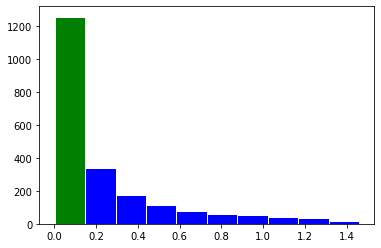

In [195]:
fig, ax = plt.subplots()
data = (get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==0]))

N, bins, patches = ax.hist(data, edgecolor='white', linewidth=1)

for i in range(0,1):
    patches[i].set_facecolor('g')
for i in range(1, len(patches)):
    patches[i].set_facecolor('blue')

plt.show()

No handles with labels found to put in legend.


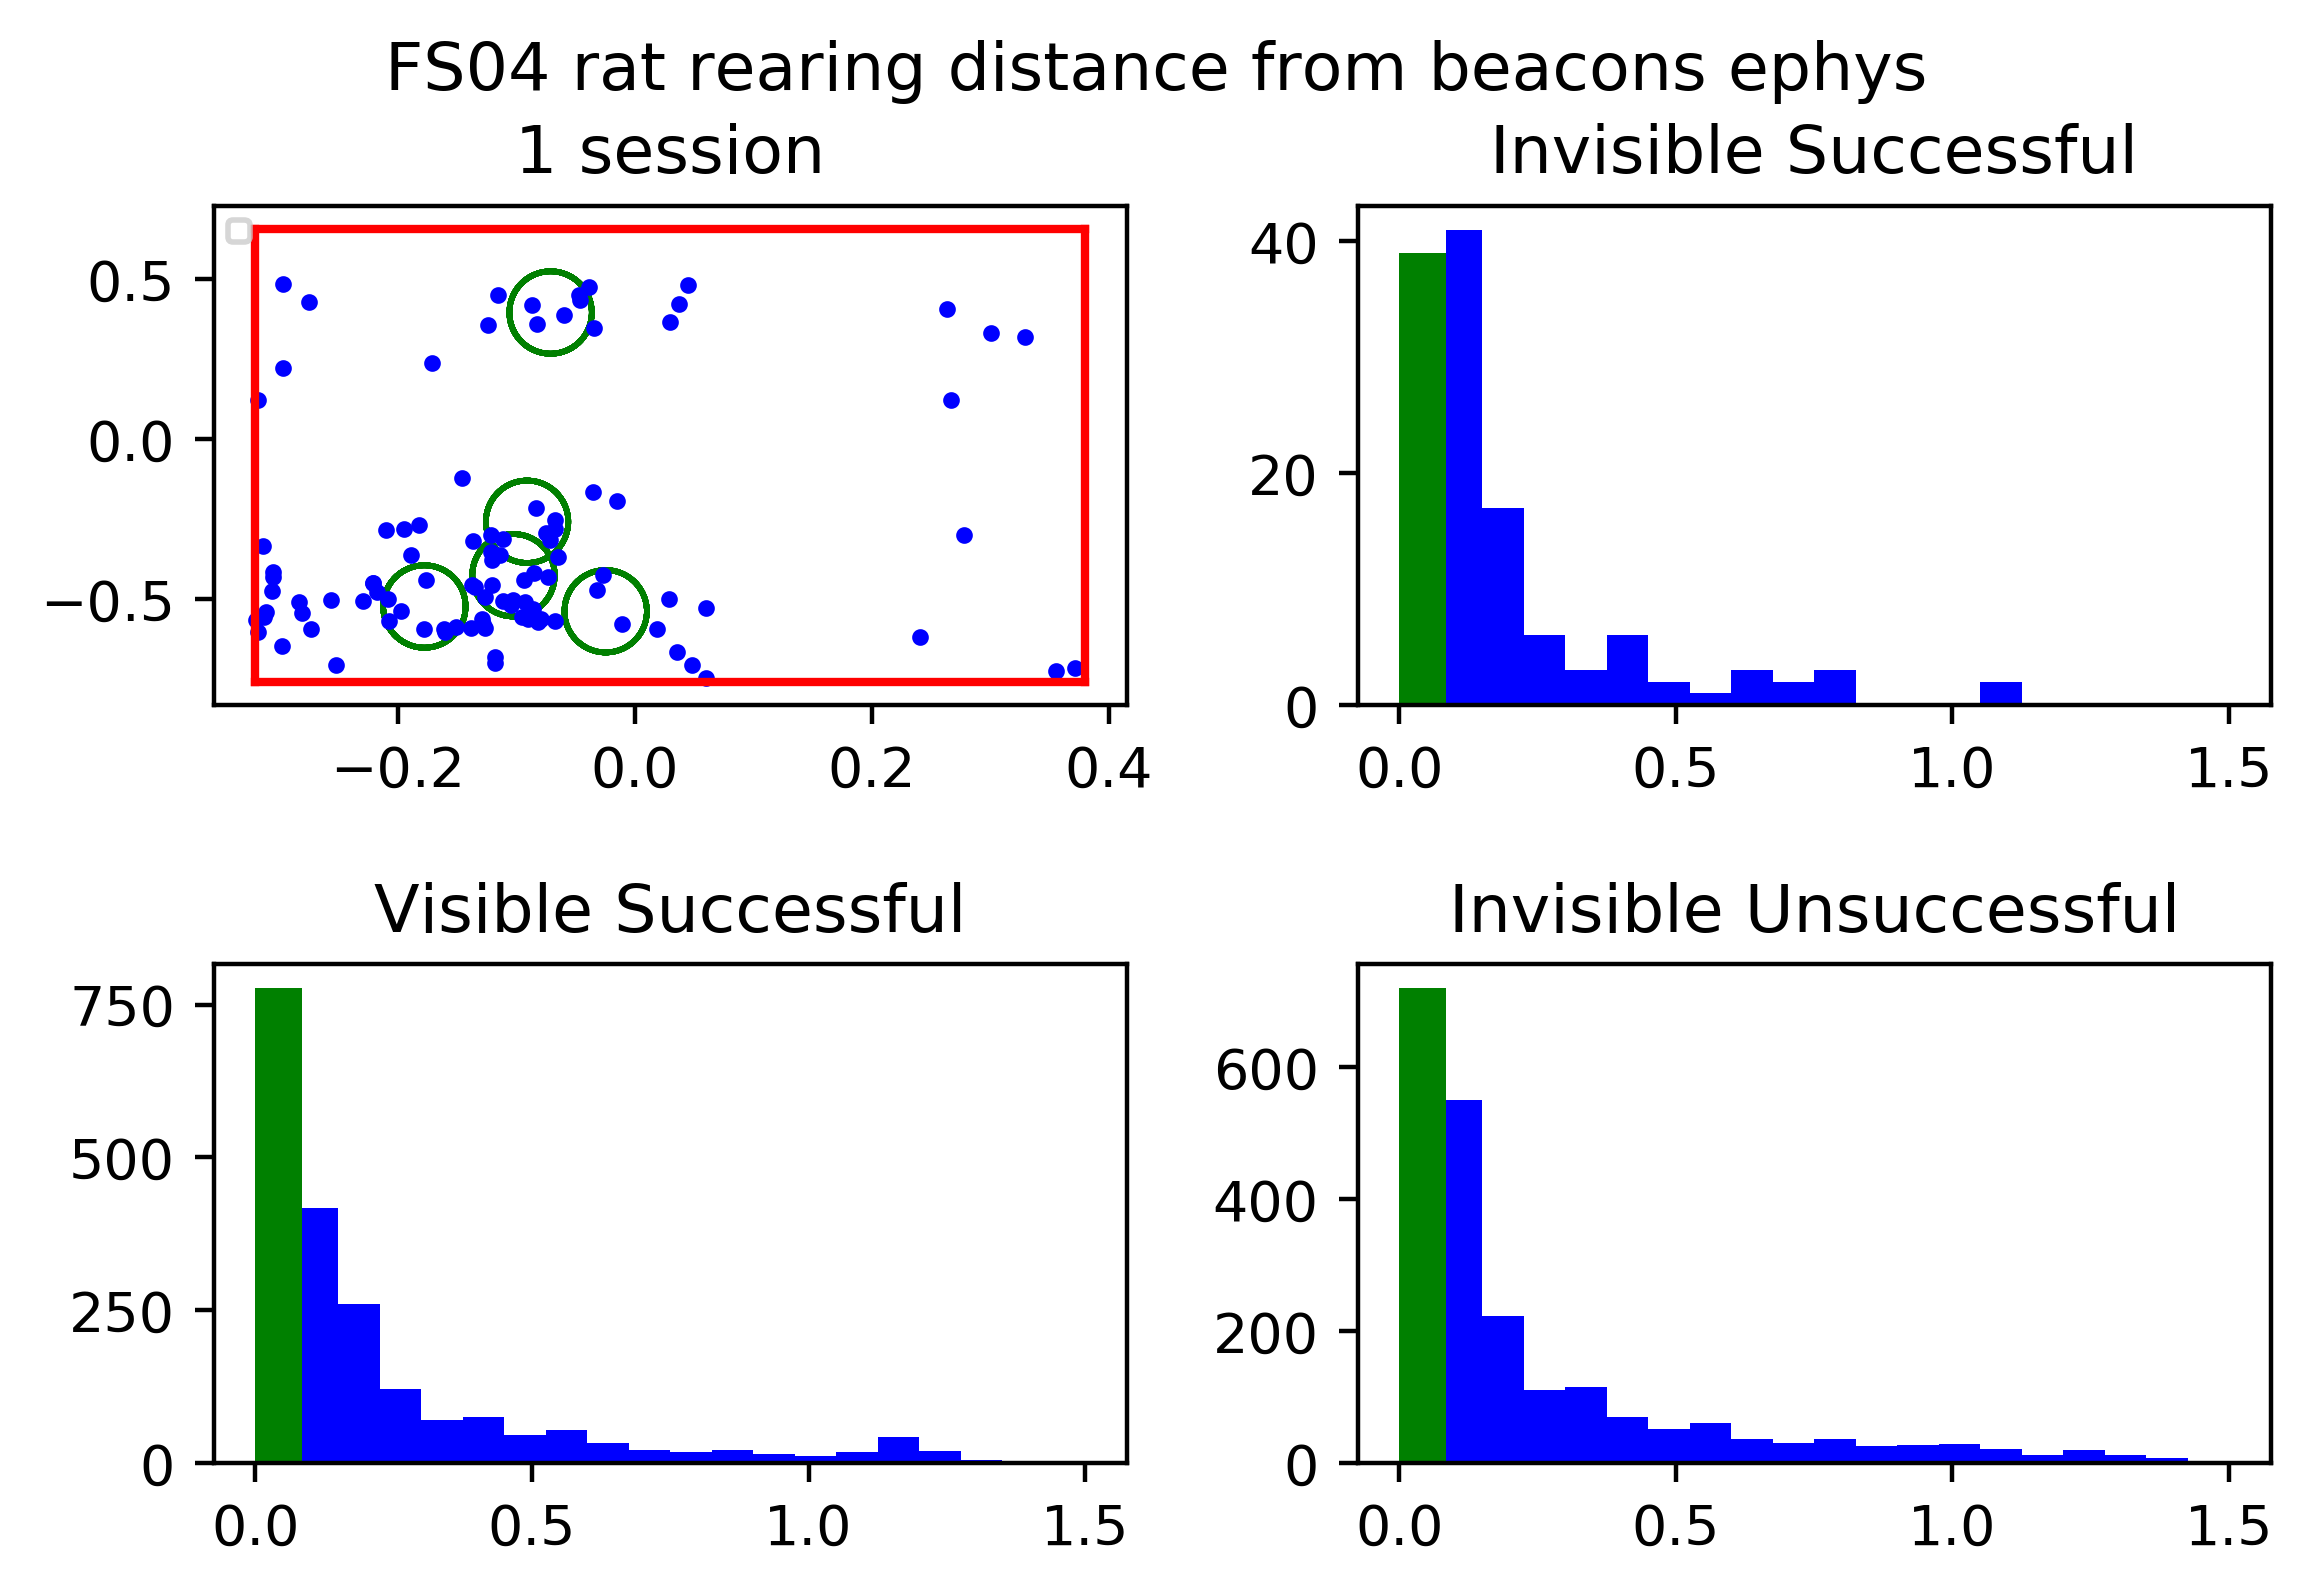

In [225]:
#rearing = 
def make_graphs (animal_ID,rearing):
    
    plt.tight_layout
    bins = np.arange(0, 1.5 + binwidth, binwidth)
    bins[1]= 0.085
    fig, ax = plt.subplots(2,2,dpi=400,sharex=False)
    fig.suptitle(animal_ID +' rat rearing distance from beacons ephys',y=1)
    #ax[0][0].bar(day_list_short,sorted_data['Pellets'],label='pellets',color ='g')
    #ax[0][0].bar(day_list_short,sorted_data['high pellets'],label='high pellets',color ='y')
    ax[0][0].set_title('1 session')
    ax[0][0].legend(loc='upper left',prop={'size': 5})
    ax[0][0].plot(rr[1],rr[2],'bo',ms=2)
    ax[0][0].plot([(X_cut_min+cut)-x_offset,(X_cut_max-cut)-x_offset],[(Y_cut_max-cut)+y_offset,(Y_cut_max-cut)+y_offset] ,'r-')
    ax[0][0].plot([(X_cut_min+cut)-x_offset,(X_cut_min+cut)-x_offset],[(Y_cut_min+cut)+y_offset,(Y_cut_max-cut)+y_offset] ,'r-')
    ax[0][0].plot([(X_cut_max-cut)-x_offset,(X_cut_max-cut)-x_offset],[(Y_cut_min+cut)+y_offset,(Y_cut_max-cut)+y_offset] ,'r-')
    ax[0][0].plot([(X_cut_max-cut)-x_offset,(X_cut_min+cut)-x_offset],[(Y_cut_min+cut)+y_offset,(Y_cut_min+cut)+y_offset] ,'r-')
    ax[0][0].scatter(rr[4],rr[5],s=220,marker='o', facecolors='none', edgecolors='green')
    #ax[1][1].set_xlabel('day')
    #ax[1][0].set_xlabel('day')
    #ax[0][0].set_ylabel('pellets')


    N, bins, patches=ax[0][1].hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==2]),bins=bins)
#     ax[0][1].plot(day_list_short,sorted_data['Sham'],label = 'sham')
#     ax[0][1].legend(loc='upper left',prop={'size': 5})
    ax[0][1].set_title('Invisible Successful')
#     #ax[0][1].set_ylabel('time in beacon')
    for i in range(0,1):
        patches[i].set_facecolor('g')
    for i in range(1, len(patches)):
        patches[i].set_facecolor('blue')
        fig.tight_layout(pad=1.5)
    N, bins, patches=ax[1][0].hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==1]),bins=bins)
#     ax[1][0].plot(day_list_short,sorted_data['Distance'], label = 'distance')
#     ax[1][0].legend(loc='upper left',prop={'size': 5})
    ax[1][0].set_title('Visible Successful')
#     ax[1][0].set_ylabel('meters')
#     ax[1][0].tick_params(axis="x", labelsize=6, labelrotation=-60, labelcolor="turquoise")

    for i in range(0,1):
        patches[i].set_facecolor('g')
    for i in range(1, len(patches)):
        patches[i].set_facecolor('blue')
        fig.tight_layout(pad=1.5)
    

    N, bins, patches = ax[1][1].hist(get_rear_distance_from_beacon(rearing.loc[rearing['Visibility']==0]),bins=bins)
#     ax[1][1].plot(day_list_short,sorted_data['Speed'],label= 'speed',color = 'cyan')
#     ax[1][1].legend(loc='upper left',prop={'size': 5})
    ax[1][1].set_title('Invisible Unsuccessful')
#     ax[1][1].tick_params(axis="x", labelsize=6, labelrotation=-60, labelcolor="turquoise")
    
    for i in range(0,1):
        patches[i].set_facecolor('g')
    for i in range(1, len(patches)):
        patches[i].set_facecolor("blue")
        fig.tight_layout(pad=1.5)
    
    #plt.show()
    plt.savefig('%srat_rearing_distance_from_beacons_new%s.png'%(figures,animal_ID), dpi = 100)

    
make_graphs('FS04' ,rearing_FS04)    

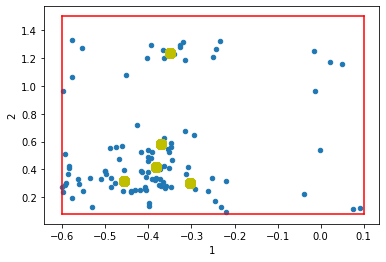

areas: -0.9939999999999999


In [134]:
cut=0
Z_points.plot.scatter(x=1, y=2)
plt.plot([(X_cut_min+cut),(X_cut_max-cut)],[(Y_cut_max-cut),(Y_cut_max-cut)] ,'r-')
plt.plot([(X_cut_min+cut),(X_cut_min+cut)],[(Y_cut_min+cut),(Y_cut_max-cut)] ,'r-')
plt.plot([(X_cut_max-cut),(X_cut_max-cut)],[(Y_cut_min+cut),(Y_cut_max-cut)] ,'r-')
plt.plot([(X_cut_max-cut),(X_cut_min+cut)],[(Y_cut_min+cut),(Y_cut_min+cut)] ,'r-')
plt.plot(rr[4]+x_offset,rr[5]-y_offset,'yo',ms=10)

plt.savefig('%srears_all.png' %(figures), dpi = 200) 

plt.show()
print ('areas: %s' %((X_cut_min-X_cut_max)*(Y_cut_max-Y_cut_min))) 

# GRAVEYARD`

## Try to catch so that it is the smallest value int the beacon 

In [17]:
df_rears = Z_points
Xs=[]
Ys=[]
for row in Z_points.iterrows():
    #print(row[1][0])

    k = FS03_beacon.iloc[(FS03_beacon[0] - row[1][0]).abs().argsort()[:1]]
    #print(k.values[0][4])
    

    timept = k.values[0][0]
    while timept > row[1][0] and k.index>0:
        
        timept = k.values[0][0]
        k_idx = k.index
        k = FS03_beacon.iloc[k_idx-1] 
        
    Xs.append(k.values[0][4])
    Ys.append(k.values[0][5])


    #print(FS03_position[0][list(k.index)])
    #pos_index.append(int(''.join(map(str,list(k.index)))))
df_rears[4]=Xs
df_rears[5]=Ys
#df_rears

In [18]:
pos_index=[]
invis=[]
#for ind in FS03_beacon.index:
df = FS03_beacon[0].diff().to_frame()
for ind in df.index:
    if df[0][ind]<60 and not (ind % 2 == 0):
        invis.append(ind)
        #print(FS03_beacon[0][ind])
        k = FS03_position.iloc[(FS03_position[0] - FS03_beacon[0][ind]).abs().argsort()[:1]]
        #print(list(k.index))
        #print(FS03_position[0][list(k.index)])
        pos_index.append(int(''.join(map(str,list(k.index)))))
invis
pos_index

[11402, 23433, 56610, 70657, 105457]

In [19]:
pos_index=[]
invis=[]
#for ind in FS03_beacon.index:
df = FS03_beacon[0].diff().to_frame()
for ind in df.index:
    if df[0][ind]<60 and not (ind % 2 == 0):
        invis.append(ind)
        #print(FS03_beacon[0][ind])
        k = Z_points.iloc[(Z_points[0] - FS03_beacon[0][ind]).abs().argsort()[:1]]
        #print(list(k.index))
        #print(FS03_position[0][list(k.index)])
        pos_index.append(int(''.join(map(str,list(k.index)))))
invis
pos_index

[11, 23, 59, 77, 100]